# ML Skill Exercise - Alberto Marengo

Assignment text

In our surveys, we ask a combination of both open-ended and closed-ended questions. In this exercise, you will be analyzing open text responses from a survey question which asked the following:
● Why are you cancelling?
Our team has already analyzed these responses to construct themes that will be useful for our clients to understand in terms of quality (what they are) and quantity (how many of each there are). As is the case with all of our projects, the ultimate goal is to use insights derived from this data to help companies make informed decisions.

You should have been given a file named coded_responses.csv
● Respondent IDs are the unique ids attached to a respondent.
● The text of their response is in the ‘response’ column
● ‘Theme’ column represents the themes we coded the data for.
Note: There can be responses which have multiple themes, those responses will have multiple rows in this file.

## Part 1

Let's start importing the packages and defining some functions we'll need for the analysis:

- `pre_process`: general text cleanup preprocessing function
- `_wordclouds`: generates wordcloud plot of input text

In [66]:
import numpy as np
import pandas as pd
import re
from matplotlib import pyplot as plt
import seaborn as sns
import pyLDAvis
import warnings
from tqdm import tqdm
from biterm.cbtm import oBTM
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from biterm.utility import vec_to_biterms, topic_summuary # helper functions

In [2]:
def pre_process(text):
    text = text.encode("ascii", "ignore");
    text = text.decode()
    text = text.lower()
    text = re.sub(pattern=r"\S*@\S*\s?", repl="", string=text)  # Emails
    text = re.sub(pattern=r"[0-9]", repl="", string=text)  # remove numbers
    text = re.sub(pattern=r"\n|\r", repl=" ", string=text)  # remove new line
    text = re.sub(pattern=r"\n|\r", repl=" ", string=text)  # remove new line
    text = re.sub(pattern=r"-[ ]*\b", repl="", string=text)  # correct words hyphenated in wrapping
    text = re.sub(pattern=r"\s+", repl=" ", string=text)  # remove white space
    text = re.sub(pattern=r"u[+]\w+", repl="", string=text)  # non-ascii conversions like "u+fb02"
    text = re.sub(pattern=r"u[+]\w+", repl="", string=text)  # non-ascii conversions like "u+fb02"
    text = re.sub(pattern=r"([a-z\._]+)[.](jpg|png|jpeg|pdf|gif)|([a-z\._]+)(jpg|png|jpeg|pdf|gif)|(jpg|png|jpeg|pdf|gif)",
                  repl="", string=text)  # image file extensions
    text = re.sub(pattern=r"(https?:\/\/|www.)+\S+", repl="", string=text)  # websites
    text = re.sub(pattern=r"[^A-Za-z0-9]+", repl=" ", string=text)  # removes non-english
    return text

In [6]:
def _wordclouds(inputs, max_words=5000):
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    long_string = ', '.join(inputs)
    # Create a WordCloud object
    wordcloud = WordCloud(background_color="white", max_words=max_words, contour_width=3,
                          contour_color='steelblue', width=900, height=900, collocations=False)
    # Generate a word cloud
    wordcloud.generate(long_string)
    ax.imshow(wordcloud)
    ax.axis('off')
    fig.suptitle('Word Cloud', fontsize=16)
    # fig.savefig(fname=f'output/wordcloud.png')

We start loading the data into a pandas DataFrame and create a boolean column for text that are longer than 3 words. We'll only keep these rows for the preliminary analysis.

In [3]:
df = pd.read_csv('data/coded_responses.csv')

In [4]:
df['keep'] = df['response'].apply(lambda text: True if len(text.split())>3 else False)
df

question  respondent_id  \
0    Why are you cancelling?        1779533   
1    Why are you cancelling?        1779397   
2    Why are you cancelling?        1779811   
3    Why are you cancelling?        1779968   
4    Why are you cancelling?        1779967   
..                       ...            ...   
658  Why are you cancelling?        1779372   
659  Why are you cancelling?        1779371   
660  Why are you cancelling?        1779370   
661  Why are you cancelling?        1779370   
662  Why are you cancelling?        1779369   

                                              response  \
0                             seen what I like already   
1      You keep canceling really good, popular series!   
2                        Getting through cell provider   
3                                          Budget cuts   
4                           Cannot have multiple users   
..                                                 ...   
658  Your pricing is terrible. You keep increasing ...   
659  Your profits are up and you're *raising* my pr...   
660  Your rates are higher than others who do the s...   
661  Your rates are higher than others who do the s...   
662                       Your stupid price hike again   

                                         theme  
0                                          NaN  
1                                          NaN  
2                                          NaN  
3    Reducing expenses / financial constraints  
4               Object to sharing restrictions  
..                                         ...  
658             Constant price rise / increase  
659             Constant price rise / increase  
660                         Prefer competition  
661                              Too expensive  
662             Constant price rise / increase  

[663 rows x 4 columns]

Let's check if we have any duplicated rows in the dataset

In [108]:
df.duplicated().any()

False

In [110]:
df[df.duplicated(subset='response')==True]

question  respondent_id  \
15   Why are you cancelling?        1779957   
25   Why are you cancelling?        1779948   
32   Why are you cancelling?        1779942   
40   Why are you cancelling?        1779935   
61   Why are you cancelling?        1779915   
..                       ...            ...   
640  Why are you cancelling?        1779387   
649  Why are you cancelling?        1779379   
657  Why are you cancelling?        1779372   
658  Why are you cancelling?        1779372   
661  Why are you cancelling?        1779370   

                                              response  \
15                 I need to change country of billing   
25   moving in with my bf. He has an subscription a...   
32   Prices keep going upward it is now too much ex...   
40        To expensive compared to others so switching   
61   Because I can�t share with my grandkids out of...   
..                                                 ...   
640  You raised your price almost 50%. I also don�t...   
649  Your company has far too many price increases....   
657  Your pricing is terrible. You keep increasing ...   
658  Your pricing is terrible. You keep increasing ...   
661  Your rates are higher than others who do the s...   

                                               theme  keep  
15                       Moving / changing locations  True  
25                       Moving / changing locations  True  
32                    Constant price rise / increase  True  
40                                     Too expensive  True  
61                    Object to sharing restrictions  True  
..                                               ...   ...  
640                   Constant price rise / increase  True  
649                   Constant price rise / increase  True  
657  Corporate greed / taking advantage of customers  True  
658                   Constant price rise / increase  True  
661                                    Too expensive  True  

[72 rows x 5 columns]

It looks like we have some duplicated response but, because they are assigned to different users, we'll keep them all.

In [5]:
df.isna().any()

question         False
respondent_id    False
response         False
theme             True
dtype: bool

It also looks like we have some Nan values in the 'theme' column.

### Wordcloud

Let's start by plotting the wordcloud of all the response to check what are the most frequent words.

In [113]:
texts = df[df['keep']==True]['response'].tolist()
texts = [pre_process(text) for text in texts]

In [114]:
len(texts)

501

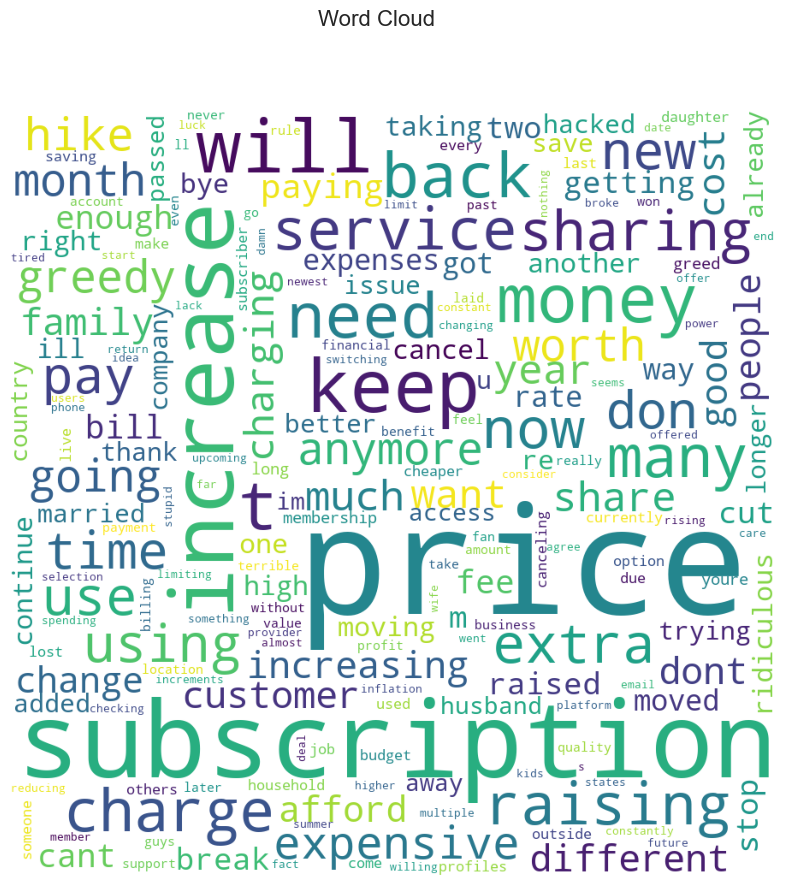

In [9]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    from imp import reload
warnings.filterwarnings('ignore')
_wordclouds(texts, max_words=200)

It looks like words 'price', 'increase', 'subscription' are the most frequent.

## Biterm Topic Model (for short text)

resource: [https://pypi.org/project/biterm/](https://pypi.org/project/biterm/)

To assign topics, we will use a specific topic model called biterm (BTM) that is well suited for short text.

The conventional topic models implicitly capture the document-level word co-occurrence patterns to reveal topics, and thus suffer from the severe data sparsity in short documents. In BTM we learn the topics by directly modeling the generation of word co-occurrence patterns (i.e. biterms) in the whole corpus. The major advantages of BTM are that:
- BTM explicitly models the word co-occurrence pat- terns to enhance the topic learning; and
- BTM uses the aggregated patterns in the whole corpus for learning topics to solve the problem of sparse word co-occurrence patterns at document-level.

The parameter inference is done using Gibbs sampling, a simple and widely applicable Markov chain Monte Carlo algorithm. The basic idea of Gibbs sampling is to estimate the parameters alternatively, by replacing the value of one variable by a value drawn from the distribution of that variable conditioned on the values of the remaining variables.

In [10]:
 # vectorize texts
# vec = CountVectorizer(stop_words='english')
vec = CountVectorizer()
X = vec.fit_transform(texts).toarray()

In [11]:
# get vocabulary
vocab = np.array(vec.get_feature_names())

# get biterms
biterms = vec_to_biterms(X)

Let's  create a training loop to try different topic numbers and get the coherence score to choose the best one.

In [12]:
def train(biterms, start=2, end=50):
    model_list = []
    topics_list = []
    coherence_score_list = []
    for num_topics in tqdm(range(start, end)):
        btm = oBTM(num_topics=num_topics, V=vocab)
        for i in range(0, len(biterms), 100): # prozess chunk of 200 texts
            biterms_chunk = biterms[i:i + 100]
            btm.fit(biterms_chunk, iterations=50)
        topics = btm.transform(biterms)
        res = topic_summuary(btm.phi_wz.T, X, vocab, df.shape[0])
        model_list.append(btm)
        topics_list.append(topics)
        coherence_score_list.append(np.mean(res['coherence']))
    return range(start, end), model_list, topics_list, coherence_score_list

In [13]:
n_range, models, topics, coherence = train(biterms)

100%|██████████| 50/50 [00:05<00:00,  8.95it/s]

100%|██████████| 50/50 [00:04<00:00, 11.28it/s]

100%|██████████| 50/50 [00:08<00:00,  5.94it/s]

100%|██████████| 50/50 [00:10<00:00,  4.60it/s]

100%|██████████| 50/50 [00:16<00:00,  3.03it/s]

100%|██████████| 50/50 [00:00<00:00, 2395.76it/s]


Topic 0 | Coherence=-327427.35 | Top words= and the to price you my for subscription is it your not prices of with too extra are that me in will keep have increase many money charge be now just raising pay greedy no this other increases charging going worth good when subscriptions only share like need using so we was has sharing back want out expensive different don more much increasing about up if people services time but use anymore re because family youre service hikes on months year after bill new dont better do am can an bye at customer as enough im paying company way raised where ill why change cheaper also daughter kept gonna reason long access hike she or greed few cancel thank cant subscriber high college sign afford anyways uses ut ridiculous years canceling charges one consider rates over moved two again already last stop keeps getting checking luck increments outside used past fact options fee without seems its added profiles got fan extortion what currently since once bein

  2%|▏         | 1/48 [00:55<43:38, 55.72s/it]

Topic 1 | Coherence=-229359.05 | Top words= you extra money share of using bill greedy about family when news back hikes power don few increase states with subscriptions outside because charging fan over be paying also past that like limit want way idea years its will your taste disgusting youre company but month subscription end payment need extortion ill move cut rotating payday else dont gas continues on new per both might spending left good gotten gonna fair got gone fact going addtional face addresses gouging hard againlater happy hand half had hacking adding addition hackednot hacked guys additional greed great grandkids go goes girl given finally focused flat fixed fix first financially financial fiance give afford feet fees feel fee after fault food for adicional forcing far again gf getting has get garbage games future fuel from frequent free forth forever hardly another have acceptance justify just joint join job jacking itself it keeping issues issue isnt isn is iny intolera


100%|██████████| 50/50 [00:05<00:00,  8.66it/s]

100%|██████████| 50/50 [00:04<00:00, 10.89it/s]

100%|██████████| 50/50 [00:08<00:00,  5.76it/s]

100%|██████████| 50/50 [00:11<00:00,  4.43it/s]

100%|██████████| 50/50 [00:17<00:00,  2.92it/s]

100%|██████████| 50/50 [00:00<00:00, 2245.66it/s]


Topic 0 | Coherence=-318874.72 | Top words= and the to price you my subscription for not of with is your extra it that in are have prices money charge me increase will just pay greedy this other be increases charging many raising subscriptions using share keep when need was sharing back want out too no different don about has worth only if services because youre like family more re hikes so bill use but on after good now dont people do company better an going bye months up as enough im ill raised we paying time cheaper change few daughter gonna reason kept also can service hike much or new anymore way thank over college ut anyways uses sign ridiculous year at one increasing years consider moved two again last taste extortion disgusting getting she cancel high past options used fan fact its fee without profiles got outside power since where being from once live continues cant upcoming news far states come even limit am already kids cut moving guys idea another ll entertaining profit add

  4%|▍         | 2/48 [01:57<45:39, 59.56s/it]

Topic 2 | Coherence=-231172.54 | Top words= of share to extra money greedy also charging about way don when outside family idea bill many news increase subscriptions using that limit back paying years fan past states hikes few be over like power month will need not want because your end move payment cut the care pay trying expenses this into double have change increasing rent upping its later from frequent free forth forever forcing layoff future learning for food focused flat fixed fuel games first garbage gotten got good gonna gone going goes go given give girl gf getting get gas fix financially laid euro let letting expected everything every even especially extortion entertainment entertaining enough life emails email expensive lesser financial fee finally fiance leave feet fees feel fault less far left legacy fair fact face last gouging increasses household huge isnt issue how issues households house husband it hosehold horrible holder history hiking hungry isn hike income incremen


100%|██████████| 50/50 [00:05<00:00,  8.60it/s]

100%|██████████| 50/50 [00:04<00:00, 10.90it/s]

100%|██████████| 50/50 [00:08<00:00,  5.75it/s]

100%|██████████| 50/50 [00:11<00:00,  4.43it/s]

100%|██████████| 50/50 [00:17<00:00,  2.93it/s]

100%|██████████| 50/50 [00:00<00:00, 2333.05it/s]


Topic 0 | Coherence=-308686.12 | Top words= and the to price you for my your of extra subscription is not will in with are be that me money charge greedy increase charging many subscriptions share increases prices have too it back pay sharing need when keep want different about good using hikes out other like family re this just only because we people if raising company youre don bye no going months now more few also way bill where paying why over change worth years im access hike greed past fan cheaper she was up am use uses college anyways ut sign so on services thank daughter one two has high reason outside ridiculous extortion disgusting taste again service kept canceling cancel increments gonna better checking luck its can do raised fee getting anymore cant since dont or from power an states news come moved got even consider kids but year limit idea fact ill ll enough being live saving terrible options new upcoming newest addition anticonsumer pricing locations another charges bud

  6%|▋         | 3/48 [03:04<47:13, 62.96s/it]

Topic 3 | Coherence=-226645.56 | Top words= using that you subscription paying about youre better extra family when money was news limit bill idea gonna kept so don if want out like services states other only keep now reason im people power outside charge increase share cheaper with raising prices warrant almost done laid changing do away goes go everything give given gone girl gf getting get gas going euro every even greedy greed emails great grandkids gouging end enough entertaining gotten entertainment especially got good games garbage far future fixed fee feel fees feet few fiance fan fair finally financial financially first fix fact flat expected focused face food for extortion forcing expensive forever forth free frequent from fault expenses fuel has guys justify joint join job jacking itself its it issues issue isnt isn is iny intolerable into interested instead just keeping increments keeps limiting limited life letting let lesser less legacy left leave learning layoff later la


100%|██████████| 50/50 [00:05<00:00,  8.35it/s]

100%|██████████| 50/50 [00:04<00:00, 10.52it/s]

100%|██████████| 50/50 [00:09<00:00,  5.54it/s]

100%|██████████| 50/50 [00:11<00:00,  4.28it/s]

100%|██████████| 50/50 [00:17<00:00,  2.82it/s]

100%|██████████| 50/50 [00:00<00:00, 2199.75it/s]


Topic 0 | Coherence=-301711.86 | Top words= and to my you the for subscription it is price in that prices have with me are your charge will not money pay keep extra when only just this going be of other need back increases like increase want different don has using so was about no now youre subscriptions more time re raising we people but much greedy after too family bill use if months services company as on bye good at better ill up increasing year worth cheaper can gonna change kept reason daughter expensive an im thank dont customer subscriber out sign anyways ut uses college consider or sharing two long share do last she already moved extortion disgusting taste charging one its many anymore paying new because cancel ridiculous since cut live continues upcoming outside high got come rates idea limit kids enough news power where make fee another states profit moving additional biannually starting saving ll feel alarming loyalty there month married locations profiles anticonsumer far 

  8%|▊         | 4/48 [04:18<49:17, 67.22s/it]

Topic 4 | Coherence=-219388.00 | Top words= using bill extra you of outside share family back don states like power paying with news about limit when idea be money to that want increase will need month payment end move break ill currently cheaper soon might trying same sense spending repurposing reflect fuel from forth future frequent free youre games garbage great grandkids gouging gotten got good gonna gone going goes go given give gf getting get gas girl fixed forever fair face extortion expensive expenses expected everything every even euro especially entertainment entertaining enough emails email elsewhere else fact fan forcing far for food focused flat greedy fix first financially financial finally fiance few feet fees feel fee fault greed having guys it justify just joint join job jacking itself its issues inflation issue isnt isn is iny intolerable into interested keep keeping keeps kept limited life letting let lesser less legacy left leave learning layoff later last laid lack


100%|██████████| 50/50 [00:05<00:00,  8.37it/s]

100%|██████████| 50/50 [00:04<00:00, 10.57it/s]

100%|██████████| 50/50 [00:08<00:00,  5.58it/s]

100%|██████████| 50/50 [00:11<00:00,  4.29it/s]

100%|██████████| 50/50 [00:17<00:00,  2.83it/s]

100%|██████████| 50/50 [00:00<00:00, 2234.13it/s]


Topic 0 | Coherence=-285820.79 | Top words= you and to the it for your my subscription price that is prices are not charge extra keep increase with raising pay have in when me just like of no only about using greedy family so will was worth increasing youre want bill if good sharing re after do bye this company going months other up people money but has share year ill don better im services enough time an cheaper subscriber uses ut college anyways sign thank reason daughter she charging dont consider rates increases paying kept last anymore customer extortion taste outside or limit disgusting out many options fact gonna its at power idea news subscriptions states because now cancel long guys make entertaining starting additional profit once terrible longer more even back far profiles we almost loyalty alarming feel come use seems biannually customers charges addition pricing different offer hike new being too card support go service again as budget much expensive without raised shady t

 10%|█         | 5/48 [05:36<51:01, 71.21s/it]

Topic 5 | Coherence=-225446.32 | Top words= extra using like bill gonna and about share money now states paying people services outside idea news other that power if when family you kept was don out better increase with of so charging my cheaper reason limit want im youre fair to retiring single apps girl going goes go given give fees gone getting get gas garbage games future gf entertainment especially good got gotten entertaining enough gouging end emails email grandkids great greed greedy elsewhere euro every even financially focused guys fixed fix far first financial feet fault fee finally fiance feel few food for fan forcing fact forever forth face extortion free expensive expenses expected frequent from everything fuel flat have hacked it justify just joint join job jacking itself its issues hackednot issue isnt isn is iny intolerable into interested keep keeping keeps kidding limiting limited life letting let lesser less legacy left leave learning layoff later last laid lack kid


100%|██████████| 50/50 [00:06<00:00,  8.13it/s]

100%|██████████| 50/50 [00:04<00:00, 10.23it/s]

100%|██████████| 50/50 [00:09<00:00,  5.38it/s]

100%|██████████| 50/50 [00:12<00:00,  4.16it/s]

100%|██████████| 50/50 [00:18<00:00,  2.74it/s]

100%|██████████| 50/50 [00:00<00:00, 2213.35it/s]


Topic 0 | Coherence=-291015.59 | Top words= the and to you price of my for your that are extra in not with subscription many money will prices me greedy increase be back charging have it subscriptions is keep using share this charge about hikes only want too if family raising when youre months different out like bill enough also more no few don need im new other people just was worth sharing services better hike has increases years good on because up fan its way cancel company gonna charges past pay kept use over extortion reason cheaper outside raised paying news fact disgusting so taste limit idea power increasing since used come we moved re states kids live bye ll time once again an almost going consider longer dont change newest addition pricing another now can continues expensive us go two ill currently even cut added break budget shady or terrible from month tried moving taking been anymore country offer times email selection try high made greed lack but fees makes forever leave 

 12%|█▎        | 6/48 [07:02<53:07, 75.90s/it]

Topic 6 | Coherence=-226969.80 | Top words= extra subscription using share about money over better that paying don youre like other states reason if so charging cheaper outside people now idea when power services kept want limit way charge news gonna was family only with of keep im hikes past subscriptions few increase years also because greedy out fan hacked longer frequent getting cannot married increases person girl give go goes gf going gone given already good greed activities added had hacking hackednot guys great got grandkids gouging gas adding gotten addition get from garbage games fees feel fee fault far fair fact face addresses extortion expensive expenses addtional expected everything every even feet fiance finally forcing future fuel hand free forth forever additional for financial food focused flat fixed fix first financially half he acct its justify just joint join job jacking itself it keeps issues issue isnt isn is iny intolerable keeping acceptance interested left absu


100%|██████████| 50/50 [00:06<00:00,  8.25it/s]

100%|██████████| 50/50 [00:04<00:00, 10.35it/s]

100%|██████████| 50/50 [00:09<00:00,  5.44it/s]

100%|██████████| 50/50 [00:11<00:00,  4.19it/s]

100%|██████████| 50/50 [00:18<00:00,  2.77it/s]

100%|██████████| 50/50 [00:00<00:00, 2166.57it/s]


Topic 0 | Coherence=-281250.17 | Top words= you my extra the subscription and to that price your of with for charging greedy are share not prices pay charge using it subscriptions about like many bill family is because was money youre hikes have other me in keep out has when so sharing company an want also increase raising if people dont just over but im don way only few fan past years after paying services better kept ill outside increases disgusting extortion taste re increasing idea gonna news do its hike without too reason or limit cheaper states up far being different cant guys now power biannually going more this consider terrible entertaining months newest charges pricing addition already one business seems what options card used even raised tried shady offer need we moved much anymore compromised almost once at kids no charged fact cancel moving wanted automatically option allowed credit told why will hiking understand were means begin cared year leave wouldn bank time ll selec

 15%|█▍        | 7/48 [08:31<54:52, 80.31s/it]

Topic 7 | Coherence=-222905.20 | Top words= using and cheaper reason only power people share gonna money keep family when increase if raising so paying services states outside kept now limit better im out like news other charge was it idea bill youre about don prices for the blindly awhile play much go going euro goes fees gone even give girl gf getting get gas given especially games entertainment good got entertaining enough gotten gouging grandkids great end greed emails greedy guys garbage every future financial fixed fix fair first fan financially finally focused fiance far few fault fee feet flat hacked fuel extortion feel from everything expected expenses expensive extra forcing frequent free forth forever face fact food havent hackednot keeps justify just joint join job jacking itself its issues issue isnt isn is iny intolerable into interested keeping kidding hacking kids little limiting limited life letting let lesser less legacy left leave learning layoff later last laid lack


100%|██████████| 50/50 [00:06<00:00,  7.93it/s]

100%|██████████| 50/50 [00:05<00:00,  9.84it/s]

100%|██████████| 50/50 [00:09<00:00,  5.27it/s]

100%|██████████| 50/50 [00:12<00:00,  4.07it/s]

100%|██████████| 50/50 [00:18<00:00,  2.68it/s]

100%|██████████| 50/50 [00:00<00:00, 2091.09it/s]


Topic 0 | Coherence=-284537.54 | Top words= and you to the my extra price for of your subscription with not charge in me charging that are is subscriptions share greedy money it different using have increase family when youre pay many prices out hikes want don other no about will if re only bye good services better increases sharing raising few im bill need going because people also cheaper over change way keep past fan reason was so years kept like we gonna company ut sign college thank anyways worth dont paying uses she daughter use be two this back outside extortion disgusting taste power its ridiculous now idea months more states limit moved an news cant too where cancel but continues anymore live come upcoming newest anticonsumer locations again won fee getting another hike on married support consider country up kids fact lack much one got since without email has makes as climb rectifying issue forever give reactivate benefit longer stay grandkids never budget added membership hig

 17%|█▋        | 8/48 [10:08<57:05, 85.63s/it]

Topic 8 | Coherence=-217466.07 | Top words= using extra bill limit paying states about money when share outside news like that increase want idea keep family don gonna power people if now kept so out reason im charge cheaper raising coming constant or you reflect summer currently good last goes fuel from gouging frequent games grandkids great greed future garbage gotten go got gas get getting gf girl gone give given going youre focused free fan fact face extortion expensive expenses expected everything every even euro especially entertainment entertaining enough end emails email fair far forth fault forever forcing for food flat fixed fix first financially financial finally fiance few feet fees feel fee greedy hardly guys it justify just joint join job jacking itself its issues inflation issue isnt isn is iny intolerable into interested keeping keeps kidding kids live little limiting limited life letting let lesser less legacy left leave learning layoff later laid lack instead incremen


100%|██████████| 50/50 [00:06<00:00,  7.91it/s]

100%|██████████| 50/50 [00:05<00:00,  9.82it/s]

100%|██████████| 50/50 [00:09<00:00,  5.26it/s]

100%|██████████| 50/50 [00:12<00:00,  4.05it/s]

100%|██████████| 50/50 [00:18<00:00,  2.68it/s]

100%|██████████| 50/50 [00:00<00:00, 2131.66it/s]


Topic 0 | Coherence=-276793.79 | Top words= you and for it to the prices is that keep charge extra not me using going your my when are increase only subscription now money no want about don raising like other with people if just good up re so services worth time too family expensive in of better youre cheaper was price share have greedy bill kept gonna reason paying much bye use im increasing more outside enough out pay charging idea limit power states will this at news as subscriber dont months thank last ut college uses anymore customer daughter anyways sign long she can even we guys back rates what profit make additional starting do sharing need loyalty alarming feel profiles there keeps kids high never fact trying many am save year consider come after forcing choice shoves keeping face nice currently again cost pop iny especially life being email were subscriptions rectifying leave forever begin reactivate give wouldn means hiking cared understand makes another issue but right cust

 19%|█▉        | 9/48 [11:50<59:01, 90.80s/it]

Topic 9 | Coherence=-208114.36 | Top words= sign she anyways uses re charge daughter ut college worth my thank bye extra in when your no good is get getting forth free gas garbage games girl future fuel from frequent gf goes give given happy hand half had hacking hackednot hacked guys greedy greed great grandkids gouging gotten got gonna gone going go forever youre forcing especially extortion expensive expenses expected everything every even euro entertainment fact entertaining enough end emails email elsewhere else eliminating face fair for finally food focused flat fixed fix first financially financial fiance family few feet fees feel fee fault far fan hard he hardly has last laid lack kids kidding kept keeps keeping keep justify just joint join job jacking itself its it issues later layoff learning limited lol locations location ll living live little limiting limit leave like life letting let lesser less legacy left issue isnt isn hike household house hosehold horrible holder histo


100%|██████████| 50/50 [00:06<00:00,  7.77it/s]

100%|██████████| 50/50 [00:05<00:00,  9.66it/s]

100%|██████████| 50/50 [00:09<00:00,  5.14it/s]

100%|██████████| 50/50 [00:12<00:00,  3.96it/s]

100%|██████████| 50/50 [00:19<00:00,  2.60it/s]

100%|██████████| 50/50 [00:00<00:00, 2075.30it/s]


Topic 0 | Coherence=-268488.66 | Top words= you extra and to my for the that charge subscription not your charging share me it of using greedy are subscriptions money pay with bill family because youre about when many want have is if increase was keep people hikes so price out services only bye sharing im better re like prices years also but no good kept raising gonna paying just other don reason cheaper going past fan in over way few an company outside taste disgusting extortion news its worth college states power do daughter uses now idea anyways thank ut limit sign cant she different without too will this after ill card fact consider kids newest even guys compromised from more charged credit told allowed option automatically wanted give bank reactivate rectifying forever makes issue back customers stay grandkids never email again come been hike what stop months how garbage time recent why city unfair fault won longer they intolerable on another parents talk fair something limited go

 21%|██        | 10/48 [13:39<1:00:58, 96.28s/it]

Topic 10 | Coherence=-212600.32 | Top words= when good sign ut going re anyways worth it thank she uses limit bye college no idea daughter outside is power about states using of charge news family don bill increase and be year started gone guys hacked games from future fuel greed frequent hackednot hacking greedy grandkids great garbage gonna gouging gotten gas get getting gf girl give given free goes got go youre forth even face extra extortion expensive expenses expected everything every euro fair especially entertainment entertaining enough end emails email elsewhere fact fan forever financially forcing for food focused had fixed fix first financial far finally fiance few feet fees feel fee fault flat he half join kidding kept keeps keeping keep justify just joint job lack jacking itself its issues issue isnt isn iny kids laid hand letting ll living live little limiting limited like life let last lesser less legacy left leave learning layoff later intolerable into interested help ho


100%|██████████| 50/50 [00:06<00:00,  7.78it/s]

100%|██████████| 50/50 [00:05<00:00,  9.69it/s]

100%|██████████| 50/50 [00:09<00:00,  5.16it/s]

100%|██████████| 50/50 [00:12<00:00,  3.96it/s]

100%|██████████| 50/50 [00:19<00:00,  2.61it/s]

100%|██████████| 50/50 [00:00<00:00, 2092.57it/s]


Topic 0 | Coherence=-274189.33 | Top words= you and the price subscription extra to your my of for that charging share with many money using greedy not don is increase was too it subscriptions out charge about family bill because people hikes now keep paying prices when youre are so like pay other raising way have just also this few gonna kept better reason cheaper want im past fan years if be services outside over news me power limit idea states more only hike access but do why increases an without canceling need am even after good checking cant we sharing greed newest ill where luck anymore card increments going care customers kids how compromised service times saving will can garbage charged deal wanted option credit automatically told customer married continuous charges problem allowed getting bank before rate stay grandkids hacked keeps re month again since got benefits take nonsense addition selection extortion member taste losing first changing gotten tracking their two drastica

 23%|██▎       | 11/48 [15:32<1:02:37, 101.56s/it]

Topic 11 | Coherence=-214915.00 | Top words= good increments luck am checking why will where greed now you too your is many canceling we increases access be greedy ridiculous constant are when non upping share raising declined thank going gotten guys forth free grandkids gouging half frequent from fuel future had hacked games garbage forever hacking gas get got getting hackednot great gf girl give gonna gone given go goes fix forcing euro extra extortion expensive expenses expected everything every even especially fact entertainment entertaining enough end emails email elsewhere else face fair for finally food focused flat fixed happy first financially financial fiance family few feet fees feel fee fault far fan hand youre hard joint kids kidding kept keeps keeping keep justify just join laid job jacking itself its it issues issue isnt lack last hardly life ll living live little limiting limited limit like letting later let lesser less legacy left leave learning layoff isn iny intolera


100%|██████████| 50/50 [00:06<00:00,  7.52it/s]

100%|██████████| 50/50 [00:05<00:00,  9.34it/s]

100%|██████████| 50/50 [00:10<00:00,  4.98it/s]

100%|██████████| 50/50 [00:13<00:00,  3.84it/s]

100%|██████████| 50/50 [00:19<00:00,  2.52it/s]

100%|██████████| 50/50 [00:00<00:00, 1953.73it/s]


Topic 0 | Coherence=-270803.97 | Top words= the and price you of your not extra prices are that subscription using money increase to keep with share my for raising charging greedy it other many hikes only is if me out like few subscriptions people services about this youre also increases in years has because when want over paying reason better gonna kept way now im past fan family cheaper don charge so months increasing worth outside bill consider good was states bye enough or news power idea limit charges far sharing no back up ill seems entertaining addition pricing daughter year come options much fact company terrible biannually already moving after will an used rectifying again email once forever makes issue reactivate have give budget getting time be thank on longer cost been but never every currently being from try tight profiles at value hand he bf talk got recent future sign just issues added continues spending get down fees lack selection we agree consolidating expected really

 25%|██▌       | 12/48 [17:33<1:04:24, 107.36s/it]

Topic 12 | Coherence=-212718.70 | Top words= you don bill family limit money when idea outside power news extra about share states using want like subscription seen back people cant sense already what change many face good gone going goes emails go given give girl end gf enough getting get gas garbage games gonna got fuel gotten hand half had hacking hackednot hacked else guys elsewhere greedy email greed great grandkids gouging future entertaining extortion fault even few feet fees every feel fee far from fan everything expected expenses fair expensive fact fiance finally financial euro frequent free forth forever entertainment forcing for food especially focused flat fixed happy first financially fix youre hard join kidding kept keeps keeping keep justify just joint job lack jacking itself its it issues issue isnt isn kids laid iny letting location ll living live little limiting limited life let last lesser less legacy left leave learning layoff later is intolerable hardly high hoseh


100%|██████████| 50/50 [00:06<00:00,  7.36it/s]

100%|██████████| 50/50 [00:05<00:00,  9.30it/s]

100%|██████████| 50/50 [00:10<00:00,  4.93it/s]

100%|██████████| 50/50 [00:13<00:00,  3.82it/s]

100%|██████████| 50/50 [00:19<00:00,  2.52it/s]

100%|██████████| 50/50 [00:00<00:00, 2037.24it/s]


Topic 0 | Coherence=-274954.46 | Top words= you and extra to your for the my of that money price is charging it with share subscription when prices me going charge not increase re keep too using greedy many about sharing like don no if want because family paying worth subscriptions much also outside bill hikes pay more anyways ut uses sign college thank states power idea way limit news bye she daughter good in now be cant people raising out past anymore fan expensive over years raised need charges few only increases dont what up an was services pricing addition newest terrible increasing stop im being shady tried this just other almost once kids used offer fact deal will can cancel saving are cost cared wouldn problem begin hike continuous understand were hiking means times without leave even another ll grandkids stay from enough upward unfortunately afford high us they as guys cheaper support longer amount so better how save youre year kept unfair something every intolerable parents r

 27%|██▋       | 13/48 [19:38<1:05:51, 112.90s/it]

Topic 13 | Coherence=-219765.81 | Top words= greedy subscriptions also way years over share fan hikes few your charging not price past many of because raising extra money prices stop damn twice months these made system people drain flat broke ridiculous lol at gas girl gf games future getting garbage get youre gonna give given hackednot hacked guys greed great grandkids gouging gotten got good from gone going goes go fuel focused frequent family fact face extortion expensive expenses expected everything every even euro especially entertainment entertaining enough end emails email fair far free fault forth forever forcing for food had fixed fix first financially financial finally fiance feet fees feel fee hacking havent half jacking keeps keeping keep justify just joint join job itself kidding its it issues issue isnt isn is iny kept kids into lesser little limiting limited limit like life letting let less lack legacy left leave learning layoff later last laid intolerable interested han


100%|██████████| 50/50 [00:06<00:00,  7.27it/s]

100%|██████████| 50/50 [00:05<00:00,  9.01it/s]

100%|██████████| 50/50 [00:10<00:00,  4.82it/s]

100%|██████████| 50/50 [00:13<00:00,  3.71it/s]

100%|██████████| 50/50 [00:20<00:00,  2.45it/s]

100%|██████████| 50/50 [00:00<00:00, 1955.66it/s]


Topic 0 | Coherence=-268752.90 | Top words= you and to greedy is the pay for subscription that my prices your price have too not me many sharing charge keep raising are extra will it just but bill because access money after family greed about why increase youre was different am taste disgusting extortion its increments checking luck we now canceling good company where increases an be want do if people subscriptions with so additional profit starting from charging last profiles re charges terrible addition pricing this year card stop ill customer without being what charged up increasing in they cancel new compromised enough told credit option wanted bank allowed automatically understand years means leave were cared wouldn begin more of ll hiking since no how only guys as fee im past high few been hikes using their us on mom ridiculous when tracking damn membership won yall constant loose longer places restrict way something upcoming over support made parents or youll also addtional can 

 29%|██▉       | 14/48 [21:50<1:07:15, 118.69s/it]

Topic 14 | Coherence=-204860.68 | Top words= money not fan few years past over hikes also greedy way enough keeps do willing increasing gf given give girl go youre getting get goes garbage games future fuel from frequent gas gonna going hacked hardly hard happy hand half had hacking hackednot guys gone greed great grandkids gouging gotten got good forth free focused forever especially extortion expensive expenses expected everything every even euro entertainment face entertaining end emails email elsewhere else eliminating el extra fact forcing financial for food have flat fixed fix first financially finally fair fiance feet fees feel fee fault far family has help havent keeping layoff later last laid lack kids kidding kept keep leave justify just joint join job jacking itself its learning left having little longer long lol locations location ll living live limiting legacy limited limit like life letting let lesser less it issues issue holder hungry huge how households household house 


100%|██████████| 50/50 [00:06<00:00,  7.31it/s]

100%|██████████| 50/50 [00:05<00:00,  9.08it/s]

100%|██████████| 50/50 [00:10<00:00,  4.85it/s]

100%|██████████| 50/50 [00:13<00:00,  3.74it/s]

100%|██████████| 50/50 [00:20<00:00,  2.46it/s]

100%|██████████| 50/50 [00:00<00:00, 1909.49it/s]


Topic 0 | Coherence=-251536.28 | Top words= you it charge is to your my for prices subscription and not so extra that raising was when re good worth only just keep if better after services are increase greedy uses using ut college anyways sign kept she thank daughter bye people youre other me cheaper reason gonna going no pay do year have out im but charging starting additional profit in now the profiles an price last ill charged card need up bill about what compromised automatically being wanted option allowed credit told wouldn were don begin bank hiking understand leave means cared enough dont without anymore us expensive married ll because every nothing high seems why added needed with much of got subscriptions two fault really getting this ok be want forth charges one memberships put customers guys even husband hacked switching too should compared think consolidating service households half profits stepdad raise recently others notified today outside we combine afford am declined 

 31%|███▏      | 15/48 [24:07<1:08:15, 124.09s/it]

Topic 15 | Coherence=-212766.09 | Top words= people im keep youre reason gonna services now charging other out better if cheaper using only kept are was raising that the extra getting get gf gas garbage hand girl games future fuel give had gone given grandkids hacking hackednot hacked guys greedy greed great gouging go gotten got good half frequent going goes from for free family fact face extortion expensive expenses expected everything every even euro especially entertainment entertaining enough end emails email elsewhere else fair fan forth far forever forcing hard food focused flat fixed fix first financially financial finally fiance few feet fees feel fee fault happy having hardly just last laid lack kids kidding keeps keeping justify joint layoff join job jacking itself its it issues issue later learning has limited lol locations location ll living live little limiting limit leave like life letting let lesser less legacy left isnt isn is hike household house hosehold horrible hol


100%|██████████| 50/50 [00:07<00:00,  7.10it/s]

100%|██████████| 50/50 [00:05<00:00,  8.85it/s]

100%|██████████| 50/50 [00:10<00:00,  4.73it/s]

100%|██████████| 50/50 [00:13<00:00,  3.64it/s]

100%|██████████| 50/50 [00:20<00:00,  2.40it/s]

100%|██████████| 50/50 [00:00<00:00, 1930.46it/s]


Topic 0 | Coherence=-264244.35 | Top words= and the price to you increase with of money about don that subscription when is using this paying for it family extra bill share not like worth outside increases just want greedy states power limit idea my prices can more anymore news enough charge have afford up raising me so profit expensive need customers no your do being keep time additional care what even other after now lost profiles pop forcing iny starting face life especially keeping nice year shoves choice make last saving currently re leave understand means were wouldn begin cared value hiking deal cant subscriber continuous if increasing problem ll longer high new at service right us again start only good before customer take times months garbage fault rate in subscriptions has sharing thanks but inflation rising cost first things waste agree made amount job by going caused pay between started get switching president compared others talk biden while pushed edge over policy continu

 33%|███▎      | 16/48 [26:31<1:09:18, 129.96s/it]

Topic 16 | Coherence=-204227.22 | Top words= starting after profiles greedy for last additional just charge is year raising prices everything opportunity getting youre get girl give gf games gas garbage future fuel from frequent free given gone go guys hard happy hand half had hacking hackednot hacked greed goes great grandkids gouging gotten got good gonna going forth food forever especially extra extortion expensive expenses expected every even euro entertainment fact entertaining enough end emails email elsewhere else eliminating face fair forcing finally has focused flat fixed fix first financially financial fiance family few feet fees feel fee fault far fan hardly he have havent learning layoff later laid lack kids kidding kept keeps keeping keep justify joint join job jacking itself its it leave left legacy live looking longer long lol locations location ll living little less limiting limited limit like life letting let lesser issues issue isnt hiking how households household hou


100%|██████████| 50/50 [00:07<00:00,  7.14it/s]

100%|██████████| 50/50 [00:05<00:00,  8.87it/s]

100%|██████████| 50/50 [00:10<00:00,  4.74it/s]

100%|██████████| 50/50 [00:13<00:00,  3.65it/s]

100%|██████████| 50/50 [00:20<00:00,  2.39it/s]

100%|██████████| 50/50 [00:00<00:00, 1905.70it/s]


Topic 0 | Coherence=-264137.07 | Top words= you extra and my the share of your subscription with charging money family to about greedy are many bill using like subscriptions price hikes me increase when has that don because company also charge not youre for an outside it prices years paying limit idea news power states fan past want over disgusting extortion taste pay way few have out its too sharing other or but different increases cant already after if entertaining without no seems far much increasing year ill biannually options im raising grandkids in stay hike consider newest at support people won anymore will dont he so longer keep bf moving addition gonna parents need someone one more kept reason better husband services daughter agree re opportunity kidding cheaper charges stepdad every being differences work any improvements profits hosehold yet squeeze months same residence change unable expensive moved now happy expenses spouse terrible was customer what who cutting unnecessar

 35%|███▌      | 17/48 [29:00<1:10:06, 135.68s/it]

Topic 17 | Coherence=-214165.35 | Top words= many price your greedy few increasing biannually or consider increases other year far because seems over hikes company entertaining ill subscriptions has much after options fan past way too years everything going emails gf give girl grandkids getting hacking get gas garbage half games had go given great goes hackednot hacked gone gonna good got gotten guys gouging greed youre forever future fuel family fair fact face extra extortion expensive expenses expected every even euro especially entertainment enough end email elsewhere else fault fee feel focused from frequent free forth happy forcing for food flat fees fixed fix first financially financial finally fiance feet hand help hard justify laid lack kids kidding kept keeps keeping keep just hardly joint join job jacking itself its it issues last later layoff learning location ll living live little limiting limited limit like life letting let lesser less legacy left leave issue isnt isn how 


100%|██████████| 50/50 [00:07<00:00,  6.94it/s]

100%|██████████| 50/50 [00:05<00:00,  8.64it/s]

100%|██████████| 50/50 [00:10<00:00,  4.61it/s]

100%|██████████| 50/50 [00:14<00:00,  3.55it/s]

100%|██████████| 50/50 [00:22<00:00,  2.26it/s]

100%|██████████| 50/50 [00:00<00:00, 1885.01it/s]


Topic 0 | Coherence=-259371.04 | Top words= and my subscription your price charge you in the extra to other for it is with are have so increases prices youre better people raising gonna services that re no worth has sign college ut anyways thank uses cheaper she im only kept daughter reason ridiculous bye if me out not good when was keep now going charging we using upcoming pay change use one where different an will already locations anticonsumer far fee greedy consider company need ill or dont like moved as benefit customer subscriptions anymore bf he more new this damn moving constant biannually climb addtional stop house seems youll don added options much kids entertaining even expensive lost between someone switching two boyfriend compared significant increasing stepdad after others choose year because away changes how putting profits fair go back users agree these mind passed yall husband issues personal policy who raises throughout twice gouging temporarily our own made history l

 38%|███▊      | 18/48 [31:36<1:10:53, 141.78s/it]

Topic 18 | Coherence=-209475.10 | Top words= using raising out was reason people kept keep charging better if only cheaper so services im that other try cut their expenses yet gas get garbage getting games future gf fuel from frequent girl going give grandkids had hacking hackednot hacked guys greedy greed great gouging given gotten got good gonna gone forth goes go free focused forever forcing face extra extortion expensive expected everything every even euro especially entertainment entertaining enough end emails email elsewhere else eliminating fact fair family financial for food hand flat fixed fix first financially finally fan fiance few feet fees feel fee fault far half youre happy hard laid lack kids kidding keeps keeping justify just joint join job jacking itself its it issues issue isnt isn last later layoff limit locations location ll living live little limiting limited like learning life letting let lesser less legacy left leave is iny intolerable her horrible holder history


100%|██████████| 50/50 [00:07<00:00,  6.97it/s]

100%|██████████| 50/50 [00:05<00:00,  8.65it/s]

100%|██████████| 50/50 [00:10<00:00,  4.62it/s]

100%|██████████| 50/50 [00:14<00:00,  3.57it/s]

100%|██████████| 50/50 [00:21<00:00,  2.35it/s]

100%|██████████| 50/50 [00:00<00:00, 1886.03it/s]


Topic 0 | Coherence=-262604.62 | Top words= for the and you price too now it your prices to not is keep are expensive worth have anymore so people me raising be many services im better charging only subscription money youre out cheaper kept much gonna using don other reason if this was increments will am just charge that increase currently way up raised my enough extra service life more afford going high years do long cant others few as pay back nice pop iny choice forcing shoves keeping especially face make but why subscriber with getting lost rates we keeps once checking budget benefits upward greedy canceling nonsense unfortunately trying luck good used access fees been try greed where who get thing changing thanks than go fault same higher us tight no possible spending continues has provider down come rules customers cut squeeze hikes even bills through use caused yet right later inflation longer offer by what market while shouldn manservices letting renewing competitive vs pick al

 40%|███▉      | 19/48 [34:16<1:11:14, 147.38s/it]

Topic 19 | Coherence=-215609.26 | Top words= charge youre reason out was gonna using better kept if you other years extra services raising charging cheaper keep the so greedy fan over that also people prices past garbage give gas get games future fuel from getting gf girl hacked given gotten hackednot guys greed great grandkids gouging got go good free gone going hacking goes frequent food forth euro face extortion expensive expenses expected everything every even especially fair entertainment entertaining enough end emails email elsewhere else fact family forever financially forcing for half focused flat fixed fix first financial far finally fiance few feet fees feel fee fault had have hand happy lack kids kidding keeps keeping justify just joint join job jacking itself its it issues issue isnt isn is laid last later like location ll living live little limiting limited limit life layoff letting let lesser less legacy left leave learning iny intolerable into her horrible holder history


100%|██████████| 50/50 [00:07<00:00,  6.77it/s]

100%|██████████| 50/50 [00:05<00:00,  8.41it/s]

100%|██████████| 50/50 [00:11<00:00,  4.50it/s]

100%|██████████| 50/50 [00:14<00:00,  3.47it/s]

100%|██████████| 50/50 [00:21<00:00,  2.28it/s]

100%|██████████| 50/50 [00:00<00:00, 1773.18it/s]


Topic 0 | Coherence=-269433.64 | Top words= you extra the for your and charging to my price subscription charge of share prices many with that subscriptions out hikes greedy me keep money because not now years youre people im also are if few past fan services way over in other was better raising sharing only gonna power kept when reason using cheaper no daughter going it so re hike cant family more too an on is will pay newest good company thank as been college another stay anyways sign grandkids without ut kids its up from months longer she like paying go support continue uses greed even won city unfair divorce future intolerable about bill through parents got squeeze profiles yet moved expected upping wife who worth idea before bye subscriber left try courtesy yall back limit kidding issues need extortion spending profits don increase stealing made live havent outside has news legacy run tired members respect one what states by games cutting town playing rate subscribers son cancelin

 42%|████▏     | 20/48 [37:03<1:11:31, 153.28s/it]

Topic 20 | Coherence=-210305.74 | Top words= using so youre reason raising better are cheaper im kept keep gonna other only people if it charge out much future gf games getting fuel from girl garbage give given gas get elsewhere go greed hand half had hacking hackednot hacked guys greedy great goes grandkids gouging gotten got good gone going free frequent for forth forever family fair fact face extra extortion expensive expenses expected everything every even euro especially entertainment entertaining enough end emails fan far fault fix forcing email food hard else focused flat fixed first fee financially financial finally fiance few feet fees feel happy he hardly justify later last laid lack kids kidding keeps keeping just learning joint join job jacking itself its issues issue layoff leave has limiting long lol locations location ll living live little limited left limit like life letting let lesser less legacy isnt isn is hike household house hosehold horrible holder history hiking 


100%|██████████| 50/50 [00:07<00:00,  6.81it/s]

100%|██████████| 50/50 [00:05<00:00,  8.44it/s]

100%|██████████| 50/50 [00:11<00:00,  4.51it/s]

100%|██████████| 50/50 [00:14<00:00,  3.48it/s]

100%|██████████| 50/50 [00:21<00:00,  2.29it/s]

100%|██████████| 50/50 [00:00<00:00, 1855.10it/s]


Topic 0 | Coherence=-255485.96 | Top words= price and my the has are subscription you me have company for your in to is few many too this or with increases like an hike ill other subscriptions youre greedy extortion already disgusting taste months its extra after entertaining biannually pay that far family it seems consider but charge about different increase charging expensive newest much budget increasing not prices year subscriber since up options life bill hikes of back nice especially choice iny shoves forcing face pop keeping money just will make more member made lost currently share into choose between over putting kids customer activities anymore moving gone was who new as deteriorated span drastically he worth so bf once selection tight come ridiculous now moved stop spending try youll addtional return happy upcoming one raised passed husband away system workable someone also sorry oneday get earlier tired owner went edge kidding pushed what againlater tightening games busines

 44%|████▍     | 21/48 [39:56<1:11:34, 159.07s/it]

Topic 21 | Coherence=-203353.99 | Top words= youre greedy charge for have taste bill extra its disgusting different about extortion but pay short amount even given future gonna gone going goes go getting give girl garbage gas good gf get games grandkids got hacking has hardly hard happy hand half had hackednot gotten hacked guys else greed great from gouging fuel elsewhere frequent fault fan family fair fact face expensive expenses expected everything every euro especially entertainment entertaining enough end emails far fee free feel forth email forcing havent food focused flat fixed fix first financially financial finally fiance few feet fees forever he having it leave learning layoff later last laid lack kids kidding kept keeps keeping keep justify just joint join job jacking left legacy less living loose looking longer long lol locations location ll live lesser little limiting limited limit like life letting let itself issues el issue husband hungry huge how households household ho


100%|██████████| 50/50 [00:07<00:00,  6.62it/s]

100%|██████████| 50/50 [00:06<00:00,  8.23it/s]

100%|██████████| 50/50 [00:11<00:00,  4.39it/s]

100%|██████████| 50/50 [00:14<00:00,  3.38it/s]

100%|██████████| 50/50 [00:22<00:00,  2.23it/s]

100%|██████████| 50/50 [00:00<00:00, 1768.33it/s]


Topic 0 | Coherence=-256613.32 | Top words= and the you increase to that my like about want of using extra don when money bill your outside family subscription paying with power states idea limit news share cancel is in greedy me terrible different almost even prices pricing pay dont shady price charge raised tried offer charges subscriptions garbage fact customers addition additional it also sharing once starting profit profiles customer just we used care since moving membership last will rate mom year currency country keep are after need location month places restrict only live two moved service be do raising household increasing fair current kids how go out cut expenses new changed rent blindly increased fiance per fault consolidating should first boyfriend up cheaper didnt limiting let profits not why have euro quality ontario newest wants gf use for single had needed kidding changes redo another set caused signaling other increases decisions putting lol forcing every issue expecte

 46%|████▌     | 22/48 [42:56<1:11:38, 165.31s/it]

Topic 22 | Coherence=-201028.06 | Top words= last year just profiles starting greedy profit additional after charge getting youre gf get give given girl garbage gas goes games future fuel from frequent free go gonna going hacked hardly hard happy hand half had hacking hackednot guys gone greed great grandkids gouging gotten got good forever forth food forcing for extra extortion expensive expenses expected everything every even euro especially entertainment entertaining enough end emails email elsewhere else eliminating face fact fair finally have focused flat fixed fix first financially financial fiance family few feet fees feel fee fault far fan has he havent issues leave learning layoff later laid lack kids kidding kept keeps keeping keep justify joint join job jacking itself its left legacy less living loose looking longer long lol locations location ll live lesser little limiting limited limit like life letting let it issue having isnt hungry huge how households household house ho


100%|██████████| 50/50 [00:07<00:00,  6.62it/s]

100%|██████████| 50/50 [00:06<00:00,  8.27it/s]

100%|██████████| 50/50 [00:11<00:00,  4.43it/s]

100%|██████████| 50/50 [00:14<00:00,  3.41it/s]

100%|██████████| 50/50 [00:22<00:00,  2.25it/s]

100%|██████████| 50/50 [00:00<00:00, 1811.67it/s]


Topic 0 | Coherence=-267614.60 | Top words= to and the price you charging be your greedy extra money of many for hikes not subscription subscriptions back raising way are prices share will charge also using people few too past fan over years other better need youre with cheaper because out services keep reason that was if gonna kept increases my it only so is im now different more can newest want profiles saving an on times hike raised additional deal continuous problem currently long break increase month year high starting payment about this end country when after don have ill taking location he profit move another going gotten up in moved moving last has time charges squeeze amount else changed currency enough family down even current renewing try me shouldn market manservices while pick drive competitive platform started new yet from go used continue payday getting pay much worth declined spend spending awhile own access rotating card dad unable limiting next addition something shor

 48%|████▊     | 23/48 [45:57<1:10:55, 170.22s/it]

Topic 23 | Coherence=-214835.57 | Top words= prices im people youre kept gonna if services was reason it now cheaper out charge keep only raising better other that so the subscription enough elsewhere get waste gas games fuel from future getting gf girl garbage going give given hackednot hacked guys greedy greed great grandkids gouging gotten got good gone free goes go frequent food forth forever fact face extra extortion expensive expenses expected everything every even euro especially entertainment entertaining end emails email else eliminating fair family fan financially forcing for had focused flat fixed fix first financial far finally fiance few feet fees feel fee fault hacking has half join lack kids kidding keeps keeping justify just joint job last jacking itself its issues issue isnt isn is laid later intolerable like location ll living live little limiting limited limit life layoff letting let lesser less legacy left leave learning iny into hand help holder history hiking hike


100%|██████████| 50/50 [00:07<00:00,  6.56it/s]

100%|██████████| 50/50 [00:06<00:00,  8.13it/s]

100%|██████████| 50/50 [00:11<00:00,  4.35it/s]

100%|██████████| 50/50 [00:14<00:00,  3.34it/s]

100%|██████████| 50/50 [00:22<00:00,  2.19it/s]

100%|██████████| 50/50 [00:00<00:00, 1789.30it/s]


Topic 0 | Coherence=-246667.04 | Top words= price and is the your you subscription we prices will too where to increases my greedy many change pay increasing access have year in increments why luck greed am canceling increase different ridiculous charge good use charges after upcoming terrible checking fee sharing addition locations anticonsumer for raising pricing people additional now of keep starting profit profiles last service are just new how subscriptions even tracking their anymore they acceptance continue up company cancel rate reality moving don try more yet lack continually provider raise value increasses months offset through squeeze consolidating each go while fiance kidding consider point delivering little charging biannually far entertaining kids nothing ill disgusting subscriber connected caring lol fair son ontario keeps phone absurd issues care sign daughter until location lower uses waiting day buggin taste extortion flat pls date often who broke out want coming next

 50%|█████     | 24/48 [49:07<1:10:27, 176.16s/it]

Topic 24 | Coherence=-204636.82 | Top words= last profit starting profiles for charge additional year increase greedy raising just to spouses married garbage gf getting forever get gas games forth from future free fuel frequent girl youre give great hand half had hacking hackednot hacked guys greed grandkids given gouging gotten got good gonna gone going go goes focused forcing food extortion expensive expenses expected everything every even euro especially entertainment entertaining enough end emails email elsewhere else eliminating el extra face fact fiance hard flat fixed fix first financially financial finally few fair feet fees feel fee fault far fan family happy havent hardly isnt layoff later laid lack kids kidding kept keeps keeping keep justify joint join job jacking itself its it issues learning leave left little longer long lol locations location ll living live limiting legacy limited limit like life letting let lesser less issue isn has is households household house hosehol


100%|██████████| 50/50 [00:07<00:00,  6.52it/s]

100%|██████████| 50/50 [00:06<00:00,  8.07it/s]

100%|██████████| 50/50 [00:11<00:00,  4.32it/s]

100%|██████████| 50/50 [00:15<00:00,  3.32it/s]

100%|██████████| 50/50 [00:22<00:00,  2.19it/s]

100%|██████████| 50/50 [00:00<00:00, 1791.73it/s]


Topic 0 | Coherence=-250642.49 | Top words= and prices you your out raising the keep are other for better price now that people services charging was charge reason gonna youre kept it to im if cheaper using so only of my extra subscription since is me months this will in hike up cancel has addition afford with pricing charges like can year stay member terrible mom just increasing have because added without more greedy gone want benefit or even climb continue drastically deteriorated span different got places cant ridiculous right lost increase rate restrict sharing job at selection what spending share not membership squeeze happy go time two live she try yet stop increasses offset oneday each earlier far budget any went passed grandkids away differences improvements raise had sorry became boyfriend continues profits owner kidding account wants hand activities vaccine already moving summer health due nothing seen caring change bye interested thank trying raises canceling agree jacking g

 52%|█████▏    | 25/48 [52:23<1:09:45, 181.97s/it]

Topic 25 | Coherence=-204374.29 | Top words= increasing sharing pricing charges greedy terrible of addition keep your going profiles users guys hacked get gas garbage hacking games had half future fuel from hand frequent happy free forth getting gf hackednot good greed great grandkids gouging gotten got gonna girl gone forever goes go given give youre food forcing face extortion expensive expenses expected everything every even euro especially entertainment entertaining enough end emails email elsewhere else eliminating el extra fact for fair hardly focused flat fixed fix first financially financial finally fiance few feet fees feel fee fault far fan family hard having has issue layoff later last laid lack kids kidding kept keeps keeping justify just joint join job jacking itself its it learning leave left little longer long lol locations location ll living live limiting legacy limited limit like life letting let lesser less issues isnt have isn how households household house hosehold 


100%|██████████| 50/50 [00:07<00:00,  6.39it/s]

100%|██████████| 50/50 [00:06<00:00,  7.93it/s]

100%|██████████| 50/50 [00:11<00:00,  4.23it/s]

100%|██████████| 50/50 [00:15<00:00,  3.26it/s]

100%|██████████| 50/50 [00:23<00:00,  2.15it/s]

100%|██████████| 50/50 [00:00<00:00, 1708.99it/s]


Topic 0 | Coherence=-259762.39 | Top words= the you for to your price too and not is many it now charging extra are subscription keep prices that charge using if me raising youre so good way people greedy will be other only better hikes was gonna cheaper kept expensive reason im services share access why am worth out going subscriptions money luck checking increments over greed also canceling years increase we few this fan where much because past have newest more again bye kids fact an consider hike back email makes service high rectifying give months forever reactivate issue willing want come currently re raised never upward unfortunately enough long my pay how no options another extortion used even intolerable unfair support anymore in afford but stupid fair live less renewing think times others while city great has creep something switching compared its given right constant declined fault later done paying maybe before amount time kidding itself from happy problem rising offered can

 54%|█████▍    | 26/48 [55:45<1:08:55, 187.96s/it]

Topic 26 | Coherence=-206648.75 | Top words= fan money also subscriptions few past extra over hikes years because way greedy charging to share made given go give goes going youre girl gf get gas garbage games future fuel from getting good gone gonna hardly hard happy hand half had hacking hackednot hacked guys greed great grandkids gouging gotten got free frequent food forth entertainment expensive expenses expected everything every even euro especially entertaining face enough end emails email elsewhere else eliminating el extortion fact forever financial forcing for focused flat fixed fix first financially finally fair fiance feet fees feel fee fault far family has health have havent later last laid lack kids kidding kept keeps keeping keep justify just joint join job jacking itself its it layoff learning leave limiting long lol locations location ll living live little limited left limit like life letting let lesser less legacy issues issue isnt history huge how households household 


100%|██████████| 50/50 [00:07<00:00,  6.39it/s]

100%|██████████| 50/50 [00:06<00:00,  7.94it/s]

100%|██████████| 50/50 [00:12<00:00,  4.15it/s]

100%|██████████| 50/50 [00:15<00:00,  3.23it/s]

100%|██████████| 50/50 [00:23<00:00,  2.13it/s]

100%|██████████| 50/50 [00:00<00:00, 1763.62it/s]


Topic 0 | Coherence=-251187.57 | Top words= you to charging your the extra for not that subscription greedy so many people it was because money few prices raising and is hikes services subscriptions also pay charge cheaper better gonna reason youre kept share over fan past keep im years are just out using my way if have only now other price of ill but an do months card after compromised bill without in this credit charged told automatically allowed wanted bank option want sharing try budget back once they stop come charges guys tight from something got cant increases wait what anymore return tracking caring take think increasing can outside second rising another first as even service reducing keeps gf fuel future keeping garbage gas get getting games into frequent expensive far family fair fact face lack extortion laid free expenses expected everything last every euro especially fault fee feel fees forth forever forcing kidding food focused flat fixed fix girl financial finally fiance 

 56%|█████▋    | 27/48 [59:13<1:07:56, 194.14s/it]

Topic 27 | Coherence=-199803.57 | Top words= keeps increasing hacking garbage go given give girl gf getting get gas youre going games future fuel from frequent free forth forever goes gone for gonna have has hardly hard happy hand half had hackednot hacked guys greedy greed great grandkids gouging gotten got good forcing food having focused expensive expenses expected everything every even euro especially entertainment entertaining enough end emails email elsewhere else eliminating el edge extortion extra face few flat fixed fix first financially financial finally fiance feet fact fees feel fee fault far fan family fair havent health he itself legacy left leave learning layoff later last laid lack kids kidding kept keeping keep justify just joint join job less lesser let location lost losing loose looking longer long lol locations ll letting living live little limiting limited limit like life jacking its your it idea husband hungry huge how households household house hosehold horrible 


100%|██████████| 50/50 [00:07<00:00,  6.28it/s]

100%|██████████| 50/50 [00:06<00:00,  7.80it/s]

100%|██████████| 50/50 [00:12<00:00,  4.15it/s]

100%|██████████| 50/50 [00:15<00:00,  3.18it/s]

100%|██████████| 50/50 [00:23<00:00,  2.09it/s]

100%|██████████| 50/50 [00:00<00:00, 1723.50it/s]


Topic 0 | Coherence=-234811.23 | Top words= you and the that increase like with money extra about family when using paying don subscription outside share bill of idea limit power my states news want price your no pay good for dont almost shady fact tried once used offer cancel also raised longer increases value its been enough agree cost run respect already members legacy frequent unable cant access what worth justify limiting hosehold rising costs high support card seen recession expenses subscriptions wont cutting choose nonesence budget out made lower pls unnecessary inflation we people biggest quality notified benefit charge more sense even gas fixed every fee garbage fault euro get games fan getting gf girl give given go goes going especially everything fair feel first focused food extortion forcing forever expensive forth free fix face expected fees financially financial finally fiance few from fuel feet future flat far youre gone increasses is iny intolerable into interested ins

 58%|█████▊    | 28/48 [1:02:48<1:06:47, 200.40s/it]

Topic 28 | Coherence=-199496.53 | Top words= youre gonna going goes go given give girl gf getting get gas garbage games future fuel from frequent free forth forever gone good he got havent have has hardly hard happy hand half had hacking hackednot hacked guys greedy greed great grandkids gouging gotten forcing for food focused expensive expenses expected everything every even euro especially entertainment entertaining enough end emails email elsewhere else eliminating el edge extortion extra face few flat fixed fix first financially financial finally fiance feet fact fees feel fee fault far fan family fair having health your less left leave learning layoff later last laid lack kids kidding kept keeps keeping keep justify just joint join job legacy lesser help let lost losing loose looking longer long lol locations location ll living live little limiting limited limit like life letting jacking itself its it if idea husband hungry huge how households household house hosehold horrible hol


100%|██████████| 50/50 [00:07<00:00,  6.31it/s]

100%|██████████| 50/50 [00:06<00:00,  7.83it/s]

100%|██████████| 50/50 [00:11<00:00,  4.17it/s]

100%|██████████| 50/50 [00:15<00:00,  3.19it/s]

100%|██████████| 50/50 [00:23<00:00,  2.10it/s]

100%|██████████| 50/50 [00:00<00:00, 1730.75it/s]


Topic 0 | Coherence=-245368.16 | Top words= you the your and prices are now subscription people price raising it that so cheaper keep better to gonna kept reason services other was access for many youre using im out too good if only charge am why charging canceling extra checking increments luck greed is where be we will pay guys when just they increase year want because every expensive how stop make their seems business tracking nothing from doesnt well making decisions others not resubscribe sense really ok but sharing added dont something at or hike before without any time switching compared in improvements differences ridiculous cannot get rate currency preemptively this euro jacking please several next discontinue stopped multiple billings enough profits prefer yearly weeks need longer greedy kids stopping days another grandkids an gouging gotten got annually gone amount anticonsumer going goes go given amounts great give amercian also already hacked almost hackednot hacking had h

 60%|██████    | 29/48 [1:06:28<1:05:17, 206.18s/it]

Topic 29 | Coherence=-197681.32 | Top words= under email youre get going goes go given give girl gf getting gas gonna garbage games future fuel from frequent free forth gone good forcing got havent have has hardly hard happy hand half had hacking hackednot hacked guys greedy greed great grandkids gouging gotten forever for he food extortion expensive expenses expected everything every even euro especially entertainment entertaining enough end emails elsewhere else eliminating el edge extra face fact fiance focused flat fixed fix first financially financial finally few fair feet fees feel fee fault far fan family having health earlier itself left leave learning layoff later last laid lack kids kidding kept keeps keeping keep justify just joint join job legacy less lesser ll losing loose looking longer long lol locations location living let live little limiting limited limit like life letting jacking its help it if idea husband hungry huge how households household house hosehold horrible


100%|██████████| 50/50 [00:08<00:00,  6.13it/s]

100%|██████████| 50/50 [00:06<00:00,  7.61it/s]

100%|██████████| 50/50 [00:12<00:00,  4.06it/s]

100%|██████████| 50/50 [00:16<00:00,  3.12it/s]

100%|██████████| 50/50 [00:24<00:00,  2.06it/s]

100%|██████████| 50/50 [00:00<00:00, 1688.34it/s]


Topic 0 | Coherence=-255095.32 | Top words= you and the that extra using keep prices subscription about for of raising are when don with share youre bill if money family charge only my increase like other charging better to outside paying people reason gonna cheaper states idea limit news power so it services kept price want was now im your out greedy its up ll us enough me re have being good means hiking cared were wouldn leave understand begin no different what high this too increases just pay many anymore we been newest upping months letting extortion be in profits has kidding bit canceling subscriptions taste charges saving over company first pushed edge taking break business legacy run month members really sick respect country cant disgusting hosehold jacking by let lol hikes need series yet unable back huge every popular cancel amounts discontinue declined off ripped days elsewhere didnt agree several quality weeks hungry lower pls billing acceptance change continue reality same 

 62%|██████▎   | 30/48 [1:10:15<1:03:41, 212.31s/it]

Topic 30 | Coherence=-209148.05 | Top words= out your people kept cheaper im gonna reason youre services better it now charge was so only there at expected enough gone going goes go given give girl good gf entertaining getting get gas entertainment garbage end got future gotten happy hand else half elsewhere had hacking hackednot email hacked emails guys greedy greed great grandkids gouging games fuel expenses from feet fees feel even fee fault every far fan family everything fair fact face extra extortion expensive few fiance euro food frequent free forth forever forcing for hardly focused finally flat especially fixed fix first financially financial hard he has keep later last laid lack kids kidding keeps keeping justify learning just joint join job jacking itself its issues layoff leave isnt limiting long lol locations location ll living live little limited left limit like life letting let lesser less legacy issue isn have hikes households household house hosehold horrible holder hi


100%|██████████| 50/50 [00:08<00:00,  6.13it/s]

100%|██████████| 50/50 [00:06<00:00,  7.60it/s]

100%|██████████| 50/50 [00:12<00:00,  4.06it/s]

100%|██████████| 50/50 [00:15<00:00,  3.13it/s]

100%|██████████| 50/50 [00:24<00:00,  2.06it/s]

100%|██████████| 50/50 [00:00<00:00, 1664.50it/s]


Topic 0 | Coherence=-253659.08 | Top words= it you price the prices and keep increasing your time for of like at is long this can many are afford will to only not far we company other out increases customer too anymore now no with subscriber charges my biannually entertaining going terrible options rates consider ill or loyalty after feel alarming there addition seems year pricing much raising just has sharing in using greedy increase by months use keeps cant benefits been being changing don share nonsense as us moved last hand letting lack but right getting see budget every selection happy thanks spending job caused hikes upping support opportunity inflation re biden president second lost work rising outside subscribers games summer playing town declined play huge increased charge days loyal jacking tired won amounts moment since coming start often got again apps justify interested if users nonesence wont stop into temporary save drastically everything that service starting am account

 65%|██████▍   | 31/48 [1:14:06<1:01:44, 217.92s/it]

Topic 31 | Coherence=-199496.53 | Top words= youre gonna going goes go given give girl gf getting get gas garbage games future fuel from frequent free forth forever gone good he got havent have has hardly hard happy hand half had hacking hackednot hacked guys greedy greed great grandkids gouging gotten forcing for food focused expensive expenses expected everything every even euro especially entertainment entertaining enough end emails email elsewhere else eliminating el edge extortion extra face few flat fixed fix first financially financial finally fiance feet fact fees feel fee fault far fan family fair having health your less left leave learning layoff later last laid lack kids kidding kept keeps keeping keep justify just joint join job legacy lesser help let lost losing loose looking longer long lol locations location ll living live little limiting limited limit like life letting jacking itself its it if idea husband hungry huge how households household house hosehold horrible hol


100%|██████████| 50/50 [00:08<00:00,  6.02it/s]

100%|██████████| 50/50 [00:06<00:00,  7.45it/s]

100%|██████████| 50/50 [00:12<00:00,  3.98it/s]

100%|██████████| 50/50 [00:16<00:00,  3.06it/s]

100%|██████████| 50/50 [00:24<00:00,  2.02it/s]

100%|██████████| 50/50 [00:00<00:00, 1630.25it/s]


Topic 0 | Coherence=-251333.47 | Top words= to extra the greedy not your you that share of charging my prices because subscription many it money also pay subscriptions hikes price past years way fan few is over when family bill but have was an about increase so just do keep youre if after only card ill re compromised charged without told enough bank up option credit allowed automatically wanted being begin wouldn understand cared leave means hiking were outside ll paying like gonna what added us better news high limit want every year this reason cheaper with good services service idea nothing kept am too ok are states really seems im power other think unable out now connected tired allow won provider euro through sharing charge using lol raising hosehold afford pleased yearly canceling go already almost getting greed great grandkids gf gouging gotten got given amercian amount amounts gone going girl give goes gas get from and finally anymore fixed fix first financially financial fiance

 67%|██████▋   | 32/48 [1:18:03<59:42, 223.89s/it]  

Topic 32 | Coherence=-199496.53 | Top words= youre gonna going goes go given give girl gf getting get gas garbage games future fuel from frequent free forth forever gone good he got havent have has hardly hard happy hand half had hacking hackednot hacked guys greedy greed great grandkids gouging gotten forcing for food focused expensive expenses expected everything every even euro especially entertainment entertaining enough end emails email elsewhere else eliminating el edge extortion extra face few flat fixed fix first financially financial finally fiance feet fact fees feel fee fault far fan family fair having health your less left leave learning layoff later last laid lack kids kidding kept keeps keeping keep justify just joint join job legacy lesser help let lost losing loose looking longer long lol locations location ll living live little limiting limited limit like life letting jacking itself its it if idea husband hungry huge how households household house hosehold horrible hol


100%|██████████| 50/50 [00:08<00:00,  6.01it/s]

100%|██████████| 50/50 [00:06<00:00,  7.46it/s]

100%|██████████| 50/50 [00:12<00:00,  3.99it/s]

100%|██████████| 50/50 [00:16<00:00,  3.07it/s]

100%|██████████| 50/50 [00:24<00:00,  2.02it/s]

100%|██████████| 50/50 [00:00<00:00, 1615.93it/s]


Topic 0 | Coherence=-238697.26 | Top words= you and my for to of with the me extra will that share charge out different charging want more in going cant but because using live be stay kids grandkids without re benefits greed nonsense price moved changing another taste country loose from extortion been too mom city fee unfair membership this intolerable youre even disgusting months currency hikes budget its keeps company don current changed sharing location how restrict places people drive market manservices competitive us shouldn newest again increase long many new return fair greedy pick againlater start down tightening there kept moving disgusts town family not job im profiles are pleased give gf wait married agree hacking alarming gone had half hand gouging happy gonna gotten hacked has guys good hardly hard hackednot got great became goes financial focused flat fixed fix first financially finally go fiance few feet fees feel allowed food allow forcing forever forth free frequent al

 69%|██████▉   | 33/48 [1:22:06<57:21, 229.46s/it]

Topic 33 | Coherence=-198974.82 | Top words= her married youre gas going goes go given give girl gf getting get garbage gonna games future fuel from frequent free forth forever gone good for hacking have has hardly hard happy hand half had hackednot got hacked guys greedy greed great grandkids gouging gotten forcing food having focused expensive expenses expected everything every even euro especially entertainment entertaining enough end emails email elsewhere else eliminating el edge extortion extra face few flat fixed fix first financially financial finally fiance feet fact fees feel fee fault far fan family fair havent health he itself left leave learning layoff later last laid lack kids kidding kept keeps keeping keep justify just joint join job legacy less lesser ll losing loose looking longer long lol locations location living let live little limiting limited limit like life letting jacking its lower it if idea husband hungry huge how households household house hosehold horrible 


100%|██████████| 50/50 [00:08<00:00,  5.90it/s]

100%|██████████| 50/50 [00:06<00:00,  7.31it/s]

100%|██████████| 50/50 [00:12<00:00,  3.88it/s]

100%|██████████| 50/50 [00:16<00:00,  3.01it/s]

100%|██████████| 50/50 [00:25<00:00,  1.98it/s]

100%|██████████| 50/50 [00:00<00:00, 1610.93it/s]


Topic 0 | Coherence=-239681.00 | Top words= you and extra that using the of subscription share prices out with your charging youre keep people about other increase charge gonna family kept reason raising money services if like cheaper im are better only don bill so my when paying outside was states idea limit now news for want it me charges cant because terrible greedy addition pricing company without is grandkids stay increasing even sharing extortion kids disgusting increases how hiking taste games tired playing begin subscribers cared hosehold lack were town unable understand means agree leave service reality expenses fair months what cutting absurd unnecessary yet high offered take free customer allowed going good almost goes gone allow go all gouging got amercian gotten give great greed alarming guys hacked hackednot hacking had half fact given feet girl fees fee am food focused flat feel fixed gf fix first financially financial finally fiance forcing forever forth frequent from a

 71%|███████   | 34/48 [1:26:15<54:54, 235.35s/it]

Topic 34 | Coherence=-204249.64 | Top words= pricing greedy charges increasing is addition keep terrible sharing prices use pay able guys give frequent future from games fuel garbage gas get getting gf girl free going given greed hard happy hand half had hacking hackednot hacked great go grandkids gouging gotten got good gonna gone goes forth for forever face extortion expensive expenses expected everything every even euro especially entertainment entertaining enough end emails email elsewhere else eliminating el extra fact forcing fair food focused flat fixed fix first financially financial finally fiance few feet fees feel fee fault far fan family hardly havent has issues learning layoff later last laid lack kids kidding kept keeps keeping justify just joint join job jacking itself its leave left legacy live looking longer long lol locations location ll living little less limiting limited limit like life letting let lesser it issue have isnt how households household house hosehold ho


100%|██████████| 50/50 [00:08<00:00,  5.91it/s]

100%|██████████| 50/50 [00:06<00:00,  7.35it/s]

100%|██████████| 50/50 [00:12<00:00,  3.92it/s]

100%|██████████| 50/50 [00:16<00:00,  3.01it/s]

100%|██████████| 50/50 [00:25<00:00,  1.97it/s]

100%|██████████| 50/50 [00:00<00:00, 1605.71it/s]


Topic 0 | Coherence=-238890.16 | Top words= the price for you of your that prices was subscription and up this my going to hike now just about it has keep if like only other before as gone care are again paying selection member being on since drastically span take deteriorated not in wife need re times months divorce when keeps amount better things start cared first understand through left is raising rate courtesy leave started used be services means wouldn enough begin ll what were hiking service profits kidding canceling stranger others offer preemptively after two lesser rising by annually next passed own changed situation climbing financial bill opportunity because wanted seems worth buggin extra newest fees subscriptions food focused flat forcing from forever its forth free frequent fix fuel future games garbage gas issues issue get fixed few itself jacking especially kept euro even every keeping justify everything joint expected expenses expensive extortion join face fact fair fa

 73%|███████▎  | 35/48 [1:30:30<52:16, 241.27s/it]

Topic 35 | Coherence=-199773.70 | Top words= if high youre get going goes go given give girl gf getting gas gonna garbage games future fuel from frequent free forth gone got good hacking have has hardly hard happy hand half had hackednot forcing hacked guys greedy greed great grandkids gouging gotten forever for having extra expensive expenses expected everything every even euro especially entertainment entertaining enough end emails email elsewhere else eliminating el edge extortion face food fact focused flat fixed fix first financially financial finally fiance few feet fees feel fee fault far fan family fair havent health he jacking legacy left leave learning layoff later last laid lack kids kidding kept keeps keeping keep justify just joint join less lesser let location lost losing loose looking longer long lol locations ll letting living live little limiting limited limit like life job itself your its ill idea husband hungry huge how households household house hosehold horrible ho


100%|██████████| 50/50 [00:08<00:00,  5.81it/s]

100%|██████████| 50/50 [00:06<00:00,  7.23it/s]

100%|██████████| 50/50 [00:12<00:00,  3.85it/s]

100%|██████████| 50/50 [00:16<00:00,  2.96it/s]

100%|██████████| 50/50 [00:25<00:00,  1.95it/s]

100%|██████████| 50/50 [00:00<00:00, 1592.55it/s]


Topic 0 | Coherence=-241131.21 | Top words= you and to it my charge for that prices the up not re when increase price in keep enough can more going greedy don just what time use as every kids is of year last if being hiking were means only cared leave understand begin ll wouldn go good about many us but high this even raising got with really continues seems nothing by months another two married need unfair intolerable city live see continue customers fault memberships moved ok how added people squeeze cant have do try yet no husband declined raise kidding days jacking card justify fair starting recently allow pay im tired profits was money reflect summer gf increases profiles gonna annually gouging gone anticonsumer an goes gotten am grandkids hacking hand half had happy hardly amercian hackednot great hacked any guys amount hard greed amounts biased given financial focused flat fixed fix first financially finally give fiance few feet fees feel fee food anyways forcing forever forth fr

 75%|███████▌  | 36/48 [1:34:50<49:24, 247.03s/it]

Topic 36 | Coherence=-199496.53 | Top words= youre gonna going goes go given give girl gf getting get gas garbage games future fuel from frequent free forth forever gone good he got havent have has hardly hard happy hand half had hacking hackednot hacked guys greedy greed great grandkids gouging gotten forcing for food focused expensive expenses expected everything every even euro especially entertainment entertaining enough end emails email elsewhere else eliminating el edge extortion extra face few flat fixed fix first financially financial finally fiance feet fact fees feel fee fault far fan family fair having health your less left leave learning layoff later last laid lack kids kidding kept keeps keeping keep justify just joint join job legacy lesser help let lost losing loose looking longer long lol locations location ll living live little limiting limited limit like life letting jacking itself its it if idea husband hungry huge how households household house hosehold horrible hol


100%|██████████| 50/50 [00:08<00:00,  5.82it/s]

100%|██████████| 50/50 [00:06<00:00,  7.25it/s]

100%|██████████| 50/50 [00:12<00:00,  3.86it/s]

100%|██████████| 50/50 [00:16<00:00,  2.97it/s]

100%|██████████| 50/50 [00:25<00:00,  1.95it/s]

100%|██████████| 50/50 [00:00<00:00, 1556.95it/s]


Topic 0 | Coherence=-246370.45 | Top words= and price your is to the you my charge it in for extra re are not when worth have me she college sign ut thank anyways uses daughter raising going good increases pay bye no ridiculous change different will use we upcoming subscription where locations anticonsumer that fee prices greedy im gonna people reason kept better anymore up constant so don using because cheaper kidding profits or raised household share limiting us high of differences time any improvements without fault access make raises single stop throughout sharing history choice policy only buggin customers youre sick biggest before lost entertainment damn face keeps fiance finally fixed few financial financially first itself feet fix fees higher focused flat feel its food issues forcing forever forth free frequent issue from fuel jacking joint job join later end enough last entertaining especially laid euro even lack every everything expected expenses kids expensive extortion keep

 77%|███████▋  | 37/48 [1:39:16<46:17, 252.53s/it]

Topic 37 | Coherence=-199496.53 | Top words= youre gonna going goes go given give girl gf getting get gas garbage games future fuel from frequent free forth forever gone good he got havent have has hardly hard happy hand half had hacking hackednot hacked guys greedy greed great grandkids gouging gotten forcing for food focused expensive expenses expected everything every even euro especially entertainment entertaining enough end emails email elsewhere else eliminating el edge extortion extra face few flat fixed fix first financially financial finally fiance feet fact fees feel fee fault far fan family fair having health your less left leave learning layoff later last laid lack kids kidding kept keeps keeping keep justify just joint join job legacy lesser help let lost losing loose looking longer long lol locations location ll living live little limiting limited limit like life letting jacking itself its it if idea husband hungry huge how households household house hosehold horrible hol


100%|██████████| 50/50 [00:08<00:00,  5.72it/s]

100%|██████████| 50/50 [00:07<00:00,  7.11it/s]

100%|██████████| 50/50 [00:13<00:00,  3.78it/s]

100%|██████████| 50/50 [00:17<00:00,  2.92it/s]

100%|██████████| 50/50 [00:26<00:00,  1.92it/s]

100%|██████████| 50/50 [00:00<00:00, 1532.23it/s]


Topic 0 | Coherence=-242267.70 | Top words= my you it not charge the is and in your daughter re for going worth to extra anyways ut when she sign uses college thank good bye no me with subscription just increase can this many moved time use as months using last will by price but has now see at don moving who budget power spending anymore happy rejoin really subscriber youre same paying get son residence once news how settled sub living justify later times disappointed allow temporarily interested cancelling need family im someone kidding kept extortion spouses increased caring another too twice checking competitive cant isn owner high gone hard already goes gonna given give girl gf getting go gotten almost hacked hand half had hacking allowed hackednot guys got greedy greed great grandkids gouging hardly bf fuel also gas financially financial finally fiance few feet fees feel fee fault far fan amount fair fact first fix fixed frequent garbage games future alarming am from free flat for

 79%|███████▉  | 38/48 [1:43:48<43:03, 258.36s/it]

Topic 38 | Coherence=-199103.79 | Top words= doesnt that gas going goes go given give girl gf getting get youre gonna garbage games future fuel from frequent free forth forever gone good for hacking have has hardly hard happy hand half had hackednot got hacked guys greedy greed great grandkids gouging gotten forcing food earlier focused expensive expenses expected everything every even euro especially entertainment entertaining enough end emails email elsewhere else eliminating el edge extortion extra face few flat fixed fix first financially financial finally fiance feet fact fees feel fee fault far fan family fair havent having he legacy leave learning layoff later last laid lack kids kidding kept keeps keeping keep justify just joint join job jacking left less health lesser losing loose looking longer long lol locations location ll living live little limiting limited limit like life letting let itself its it issues idea husband hungry huge how households household house hosehold hor


100%|██████████| 50/50 [00:08<00:00,  5.73it/s]

100%|██████████| 50/50 [00:07<00:00,  7.12it/s]

100%|██████████| 50/50 [00:13<00:00,  3.80it/s]

100%|██████████| 50/50 [00:17<00:00,  2.91it/s]

100%|██████████| 50/50 [00:26<00:00,  1.92it/s]

100%|██████████| 50/50 [00:00<00:00, 1577.94it/s]


Topic 0 | Coherence=-245303.49 | Top words= for subscription are my company charge youre the you disgusting taste greedy its extortion family about me idea pay bill using raising now extra money but have subscriptions prices services to your other and on it increasing much of want entertaining going far after don year paying biannually options increases like with divorce seems consider when spend or as im left wife kids fair courtesy through passed cancel increase another different even cheaper news waste outside away kept reason rather how learning didnt let would between many kidding first time ill owner month power personal moving issues users own thank cost aunt anymore hikes right wants support done that understand amercian hacking happy hand half am gone gonna also had good already almost great got gotten hackednot allow hacked guys gouging grandkids allowed greed biden amount goes fixed forever forcing an food focused flat fix go financially financial finally fiance few feet for

 81%|████████▏ | 39/48 [1:48:25<39:34, 263.86s/it]

Topic 39 | Coherence=-207495.40 | Top words= prices much other ill increasing consider biannually your after or far increases year seems options else give given go goes youre girl going getting get gas garbage games future gf got gone hacked hardly hard happy hand half had hacking hackednot guys gonna greedy greed great grandkids gouging gotten from good fuel forever frequent family fact face extra extortion expensive expenses expected everything every even euro especially entertainment entertaining enough end emails email elsewhere fair fan free fault forth have forcing for food focused flat fixed fix first financially financial finally fiance few feet fees feel fee has her havent keeps layoff later last laid lack kids kidding kept keeping leave keep justify just joint join job jacking itself learning left having little longer long lol locations location ll living live limiting legacy limited limit like life letting let lesser less its it issues history huge how households household h


100%|██████████| 50/50 [00:08<00:00,  5.59it/s]

100%|██████████| 50/50 [00:07<00:00,  6.97it/s]

100%|██████████| 50/50 [00:13<00:00,  3.72it/s]

100%|██████████| 50/50 [00:17<00:00,  2.85it/s]

100%|██████████| 50/50 [00:26<00:00,  1.88it/s]

100%|██████████| 50/50 [00:00<00:00, 1533.27it/s]


Topic 0 | Coherence=-252971.74 | Top words= and you the to price that charge for other using services keep my prices subscription youre raising people better will it in are reason gonna kept cheaper im out so charging if pay your only me was now have extra different change use fee is we money where increases more ridiculous anticonsumer locations upcoming re going kids want live new cancel not don from greed another been since on dont need mom save membership loose restrict places unfair city intolerable much as sharing charges even sign uses fair years two how yall stealing havent because ut anyways kidding profits fault reality spend wants adding boyfriend history cost raises canceling lack throughout make never choose member quality who greedy increasing few hungry tired like family fan garbage gas financial get finally extortion fiance forcing getting games gf feet fees girl give feel given go goes acct account flat expenses face forever everything expensive far food accounts focus

 83%|████████▎ | 40/48 [1:53:09<35:59, 269.94s/it]

Topic 40 | Coherence=-199496.53 | Top words= youre gonna going goes go given give girl gf getting get gas garbage games future fuel from frequent free forth forever gone good he got havent have has hardly hard happy hand half had hacking hackednot hacked guys greedy greed great grandkids gouging gotten forcing for food focused expensive expenses expected everything every even euro especially entertainment entertaining enough end emails email elsewhere else eliminating el edge extortion extra face few flat fixed fix first financially financial finally fiance feet fact fees feel fee fault far fan family fair having health your less left leave learning layoff later last laid lack kids kidding kept keeps keeping keep justify just joint join job legacy lesser help let lost losing loose looking longer long lol locations location ll living live little limiting limited limit like life letting jacking itself its it if idea husband hungry huge how households household house hosehold horrible hol


100%|██████████| 50/50 [00:08<00:00,  5.63it/s]

100%|██████████| 50/50 [00:07<00:00,  6.99it/s]

100%|██████████| 50/50 [00:13<00:00,  3.72it/s]

100%|██████████| 50/50 [00:17<00:00,  2.86it/s]

100%|██████████| 50/50 [00:26<00:00,  1.89it/s]

100%|██████████| 50/50 [00:00<00:00, 1568.47it/s]


Topic 0 | Coherence=-238295.59 | Top words= you and the my extra about family bill using share that subscription money increase when don of outside like with paying want idea limit power states news to are have subscriptions your rates just its do we get others but who moving thing same month in higher need expenses only cut almost is increased me than newest multiple rent fiance per consolidating limiting hosehold costs once cannot settled household rejoin workable use for users unable cant will single made billings looking stopped garbage raised system unneeded hungry reducing absurd phone much not buggin our fuel itself finally financial financially first join fix games fixed flat focused food job jacking isnt forcing forever forth few free issue frequent issues future from it joint fee feet kept end enough entertaining lack entertainment especially euro even every kids everything expected kidding expensive fees extortion keeps keeping face fact fair keep fan far fault justify gas f

 85%|████████▌ | 41/48 [1:57:57<32:08, 275.51s/it]

Topic 41 | Coherence=-202972.09 | Top words= than higher rates thing same who your do others creep my wants garbage getting get gf girl give gas youre games future go fuel from frequent free forth forever given gonna goes greedy happy hand half had hacking hackednot hacked guys greed going great grandkids gouging gotten got good for gone forcing fixed food entertainment expensive expenses expected everything every even euro especially entertaining extra enough end emails email elsewhere else eliminating el extortion face focused few flat hardly fix first financially financial finally fiance feet fact fees feel fee fault far fan family fair hard having has issue later last laid lack kids kidding kept keeps keeping keep justify just joint join job jacking itself its it layoff learning leave limiting long lol locations location ll living live little limited left limit like life letting let lesser less legacy issues isnt have isn huge how households household house hosehold horrible holder


100%|██████████| 50/50 [00:09<00:00,  5.52it/s]

100%|██████████| 50/50 [00:07<00:00,  6.86it/s]

100%|██████████| 50/50 [00:13<00:00,  3.66it/s]

100%|██████████| 50/50 [00:17<00:00,  2.81it/s]

100%|██████████| 50/50 [00:26<00:00,  1.86it/s]

100%|██████████| 50/50 [00:00<00:00, 1523.89it/s]


Topic 0 | Coherence=-239069.22 | Top words= have for is pay to and my but it so bill subscription only subscriber not youre me are taste charge disgusting extortion greedy company its just about prices you different like family keep rates was no increasing customer at subscriptions we long time loyalty alarming feel that extra there will going after do card ill life an compromised pop shoves iny keeping because charged without make told automatically wanted allowed face credit bank option especially nice choice lost forcing your up expensive worth currently anymore the price more with declined think system now workable way kids afford policy fault tried don first gf learning fair garbage gas fact leave get expenses getting laid expected far girl give given everything every go goes even euro gone fan layoff games later fix fixed flat financially financial focused finally food last fiance few feet forever fees forth fee free frequent from fuel future gonna kidding good im increases incre

 88%|████████▊ | 42/48 [2:02:54<28:11, 281.90s/it]

Topic 42 | Coherence=-199496.53 | Top words= youre gonna going goes go given give girl gf getting get gas garbage games future fuel from frequent free forth forever gone good he got havent have has hardly hard happy hand half had hacking hackednot hacked guys greedy greed great grandkids gouging gotten forcing for food focused expensive expenses expected everything every even euro especially entertainment entertaining enough end emails email elsewhere else eliminating el edge extortion extra face few flat fixed fix first financially financial finally fiance feet fact fees feel fee fault far fan family fair having health your less left leave learning layoff later last laid lack kids kidding kept keeps keeping keep justify just joint join job legacy lesser help let lost losing loose looking longer long lol locations location ll living live little limiting limited limit like life letting jacking itself its it if idea husband hungry huge how households household house hosehold horrible hol


100%|██████████| 50/50 [00:09<00:00,  5.55it/s]

100%|██████████| 50/50 [00:07<00:00,  6.89it/s]

100%|██████████| 50/50 [00:13<00:00,  3.67it/s]

100%|██████████| 50/50 [00:17<00:00,  2.80it/s]

100%|██████████| 50/50 [00:27<00:00,  1.85it/s]

100%|██████████| 50/50 [00:00<00:00, 1526.78it/s]


Topic 0 | Coherence=-254995.38 | Top words= and to the you for price my that people pay in better change have of charge is increases will now so we different sharing are where want extra ridiculous other your too gonna use keep fee youre upcoming locations cheaper anticonsumer using just services many kept was reason country only out subscriptions if more stop raising im subscription am need reality because moved kids from location guys moving they it currency lack acceptance something new be changed anymore don current family billing another re charges prices how taste fiance hike fair city intolerable live ontario caring unfair increase increasing won with consolidating amount me credit charging declined buggin think these way continuous warrant continues enough politically needed wait extortion future disgusting fuel join games frequent garbage getting free gf joint get every gas forth keeps forever everything face fact fan far fault expensive kidding feel fees feet few finally fina

 90%|████████▉ | 43/48 [2:07:55<23:58, 287.80s/it]

Topic 43 | Coherence=-199183.55 | Top words= allow sharing get going goes go given give girl gf getting youre for garbage games future fuel from frequent free forth forever gas gone gonna good have has hardly hard happy hand half had hacking hackednot hacked guys greedy greed great grandkids gouging gotten got forcing focused food having expensive expenses expected everything every even euro especially entertainment entertaining enough end emails email elsewhere else eliminating el edge extortion extra face few flat fixed fix first financially financial finally fiance feet fact fees feel fee fault far fan family fair havent he earlier legacy leave learning layoff later last laid lack kids kidding kept keeps keeping keep justify just joint join job jacking left less health lesser losing loose looking longer long lol locations location ll living live little limiting limited limit like life letting let itself its it issues idea husband hungry huge how households household house hosehold h


100%|██████████| 50/50 [00:09<00:00,  5.47it/s]

100%|██████████| 50/50 [00:07<00:00,  6.79it/s]

100%|██████████| 50/50 [00:13<00:00,  3.60it/s]

100%|██████████| 50/50 [00:18<00:00,  2.75it/s]

100%|██████████| 50/50 [00:27<00:00,  1.82it/s]

100%|██████████| 50/50 [00:00<00:00, 1502.90it/s]


Topic 0 | Coherence=-238982.96 | Top words= and it to like prices keep the increasing dont time long for rates no only at subscriber customer loyalty alarming is feel money going we there cancel will you tried pay once raised shady offer price almost save family fact used need also your other that increase as about me much just use services some month trying bill in when first idea let didnt times power cheaper euro states started adding currency financial pagos adicional el workable caused por servicio issues having right new constantly prefer platforms have taking continously hosehold two continues fees lost go given give girl gf games getting garbage from fuel future gas get finally frequent free especially even every everything expected expenses expensive extortion extra face fair fan far fault fee feet few fiance financially fix fixed flat focused food forcing forever forth goes youre gone increasses iny intolerable into interested instead inflation increments increases huge incre

 92%|█████████▏| 44/48 [2:13:03<19:35, 293.83s/it]

Topic 44 | Coherence=-199496.53 | Top words= youre gonna going goes go given give girl gf getting get gas garbage games future fuel from frequent free forth forever gone good he got havent have has hardly hard happy hand half had hacking hackednot hacked guys greedy greed great grandkids gouging gotten forcing for food focused expensive expenses expected everything every even euro especially entertainment entertaining enough end emails email elsewhere else eliminating el edge extortion extra face few flat fixed fix first financially financial finally fiance feet fact fees feel fee fault far fan family fair having health your less left leave learning layoff later last laid lack kids kidding kept keeps keeping keep justify just joint join job legacy lesser help let lost losing loose looking longer long lol locations location ll living live little limiting limited limit like life letting jacking itself its it if idea husband hungry huge how households household house hosehold horrible hol


100%|██████████| 50/50 [00:09<00:00,  5.46it/s]

100%|██████████| 50/50 [00:07<00:00,  6.77it/s]

100%|██████████| 50/50 [00:13<00:00,  3.61it/s]

100%|██████████| 50/50 [00:18<00:00,  2.75it/s]

100%|██████████| 50/50 [00:27<00:00,  1.82it/s]

100%|██████████| 50/50 [00:00<00:00, 1500.15it/s]


Topic 0 | Coherence=-247015.07 | Top words= and other the it better people kept services using gonna charging prices cheaper reason im was keep only raising you your charge to so now for if youre are more have dont money subscription as new extra no need price use customer greed we fee save much that loose will sharing charges me like climb upcoming increases this addtional fees youll from continues rates added stop adding is really household back been want long limiting profits signaling virtue political never caring disgusts single constantly monthly significant worth return some inflation increase moving constant forcing forever keeps food fixed focused flat improvements forth free frequent keeping justify fuel just fix games garbage joint gas get getting join future few first face entertaining later last entertainment especially euro even every everything expected expenses expensive extortion laid fact financially lack kids kidding fair family fan far fault feel feet girl fiance fi

 94%|█████████▍| 45/48 [2:18:16<14:58, 299.58s/it]

Topic 45 | Coherence=-199793.81 | Top words= at being getting gone going goes go given give girl gf get health gas garbage games future fuel from frequent free forth gonna good got gotten having havent have has hardly hard happy hand half had hacking hackednot hacked guys greedy greed great grandkids gouging forever youre forcing face extortion expensive expenses expected everything every even euro especially entertainment entertaining enough end emails email elsewhere else eliminating el extra fact for fair food focused flat fixed fix first financially financial finally fiance few feet fees feel fee fault far fan family he help easily jacking legacy left leave learning layoff later last laid lack kids kidding kept keeps keeping keep justify just joint join less lesser let location lost losing loose looking longer long lol locations ll letting living live little limiting limited limit like life job itself her its ill if idea husband hungry huge how households household house hosehold h


100%|██████████| 50/50 [00:09<00:00,  5.36it/s]

100%|██████████| 50/50 [00:07<00:00,  6.66it/s]

100%|██████████| 50/50 [00:14<00:00,  3.53it/s]

100%|██████████| 50/50 [00:18<00:00,  2.70it/s]

100%|██████████| 50/50 [00:27<00:00,  1.79it/s]

100%|██████████| 50/50 [00:00<00:00, 1490.84it/s]


Topic 0 | Coherence=-249538.37 | Top words= the you your charging to share extra money subscription many and not greedy hikes also that price subscriptions fan few past years way over using im when with because idea of outside like don about increase power now bill want family limit it news states are paying youre keep people cheaper other if reason so gonna kept better services an prices just was only out expenses raising cut almost increased charges rent per in month new need their moving unable ontario tracking looking charge location costs politically unneeded given summer support live hacked job made think be forth getting finally fiance euro face especially fact entertainment feet fair gf financially girl give fees go goes feel fee going fault get gas forever extortion far free forcing expected frequent from fuel future for everything games food focused every flat fixed fix expensive even garbage first financial hardly gone increasses intolerable into interested instead inflation

 96%|█████████▌| 46/48 [2:23:36<10:11, 305.67s/it]

Topic 46 | Coherence=-199496.53 | Top words= youre gonna going goes go given give girl gf getting get gas garbage games future fuel from frequent free forth forever gone good he got havent have has hardly hard happy hand half had hacking hackednot hacked guys greedy greed great grandkids gouging gotten forcing for food focused expensive expenses expected everything every even euro especially entertainment entertaining enough end emails email elsewhere else eliminating el edge extortion extra face few flat fixed fix first financially financial finally fiance feet fact fees feel fee fault far fan family fair having health your less left leave learning layoff later last laid lack kids kidding kept keeps keeping keep justify just joint join job legacy lesser help let lost losing loose looking longer long lol locations location ll living live little limiting limited limit like life letting jacking itself its it if idea husband hungry huge how households household house hosehold horrible hol


100%|██████████| 50/50 [00:09<00:00,  5.36it/s]

100%|██████████| 50/50 [00:07<00:00,  6.66it/s]

100%|██████████| 50/50 [00:14<00:00,  3.54it/s]

100%|██████████| 50/50 [00:18<00:00,  2.70it/s]

100%|██████████| 50/50 [00:27<00:00,  1.79it/s]

100%|██████████| 50/50 [00:00<00:00, 1486.64it/s]


Topic 0 | Coherence=-240514.20 | Top words= and to you for my me charge is extra have in your pay price different it going re worth good thank sign uses anyways college ut she daughter are youre when bye no company greedy not taste extortion disgusting increases its the but about family bill subscriptions prices change we ridiculous where upcoming use fee keep anticonsumer locations subscription will raising on money of services been from because years don havent yall stealing better stop offer anymore continously restriction fault others lesser declined allow buggin fair twice itself rising flat girl given go feet goes fees adding gone addtional gonna added got gotten gouging feel grandkids far fan addresses great greed face activities guys hacked hackednot fact give addition expected financially food fixed additional forcing fix hacking forever forth expensive first free expenses frequent focused financial finally fuel fiance future games garbage gas get getting few gf amount help ha

 98%|█████████▊| 47/48 [2:29:01<05:11, 311.47s/it]

Topic 47 | Coherence=-199496.53 | Top words= youre gonna going goes go given give girl gf getting get gas garbage games future fuel from frequent free forth forever gone good he got havent have has hardly hard happy hand half had hacking hackednot hacked guys greedy greed great grandkids gouging gotten forcing for food focused expensive expenses expected everything every even euro especially entertainment entertaining enough end emails email elsewhere else eliminating el edge extortion extra face few flat fixed fix first financially financial finally fiance feet fact fees feel fee fault far fan family fair having health your less left leave learning layoff later last laid lack kids kidding kept keeps keeping keep justify just joint join job legacy lesser help let lost losing loose looking longer long lol locations location ll living live little limiting limited limit like life letting jacking itself its it if idea husband hungry huge how households household house hosehold horrible hol


100%|██████████| 50/50 [00:09<00:00,  5.28it/s]

100%|██████████| 50/50 [00:07<00:00,  6.57it/s]

100%|██████████| 50/50 [00:14<00:00,  3.49it/s]

100%|██████████| 50/50 [00:18<00:00,  2.66it/s]

100%|██████████| 50/50 [00:28<00:00,  1.76it/s]

100%|██████████| 50/50 [00:00<00:00, 1456.11it/s]


Topic 0 | Coherence=-239065.94 | Top words= price the and too subscription where many is have increases we change will pay my to different ridiculous fee use greedy for in keep locations anticonsumer upcoming charging sharing hike your newest an you share charges me money from pricing gotten service checking why been luck are extra because access years times increments constant disgusting reality good canceling terrible greed on addition yall account acceptance stealing havent raised hikes passed going lack she be away am had better caring mom new parent summer lol using history now throughout owning quality activities health card buggin afford raises reflect manservices else opening member added restrict go every everything give fact even goes face given getting extortion expensive expected girl gf expenses financial get fair gone fiance financially first fix few feet fixed flat focused food forcing forever forth free fees frequent feel fault fuel far fan family future finally garbage

100%|██████████| 48/48 [2:34:32<00:00, 193.18s/it]

Topic 48 | Coherence=-201221.63 | Top words= to vaccine else on getting going goes go given give girl gf youre gone gas garbage games future fuel from frequent free forth get good gonna hacking have has hardly hard happy hand half had hackednot got hacked guys greedy greed great grandkids gouging gotten forever forcing having face extortion expensive expenses expected everything every even euro especially entertainment entertaining enough end emails email elsewhere eliminating el edge extra fact for fair food focused flat fixed fix first financially financial finally fiance few feet fees feel fee fault far fan family havent health he its leave learning layoff later last laid lack kids kidding kept keeps keeping keep justify just joint join job jacking left legacy less living loose looking longer long lol locations location ll live lesser little limiting limited limit like life letting let itself it earlier issues idea husband hungry huge how households household house hosehold horrible

After training let's have a look at the coherence scores to choose the ideal topic number.

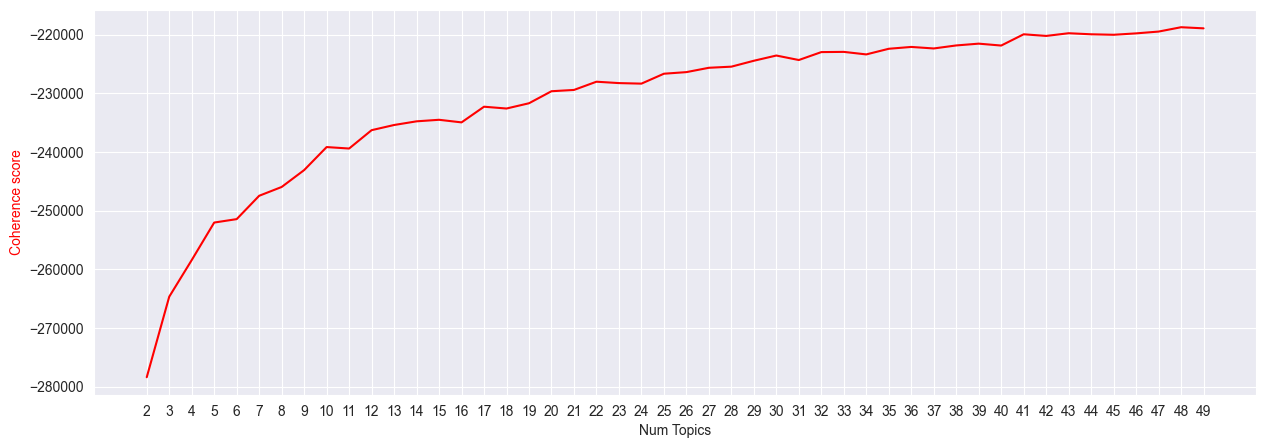

In [15]:
x = n_range
y_coherence = coherence
fig, ax1 = plt.subplots(figsize=(15, 5))
ax1.plot(x, y_coherence, c='r')
ax1.set_xticks(x)
ax1.set_xlabel("Num Topics")
ax1.set_ylabel("Coherence score", color='r')
plt.show()

It looks like 10 topics is a good starting point. That's where the line shows the start of flattening, and it's still easy to explain.

In [76]:
num_topics = 10

In [77]:
# create btm
btm = oBTM(num_topics=num_topics, V=vocab)

In [79]:
print("\n\n Train Online BTM ..")
for i in range(0, len(biterms), 100): # prozess chunk of 200 texts
    biterms_chunk = biterms[i:i + 100]
    btm.fit(biterms_chunk, iterations=100)
topics = btm.transform(biterms)



 Train Online BTM ..


100%|██████████| 100/100 [00:00<00:00, 2266.75it/s]


Using the visualization below we can see the word distribution in each topic and name the topics accordingly.

In [80]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.prepare(btm.phi_wz.T, topics, np.count_nonzero(X, axis=1), vocab, np.sum(X, axis=0), mds='mmds')
# pyLDAvis.save_html(vis, './vis/online_btm.html')
vis

/Users/albertomerango/Coeuraj/v_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/albertomerango/Coeuraj/v_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/albertomerango/Coeuraj/v_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/albertomerango/Coeuraj/v_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/albertomerango/Coeuraj/v_env/lib/

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.116199  0.044999       1        1  21.416871
6     -0.110115 -0.128687       2        1  11.897096
3     -0.149632  0.018882       3        1  10.870841
8     -0.123282  0.162695       4        1  10.655970
2      0.289617 -0.117665       5        1  10.064493
7      0.099806 -0.258291       6        1  10.028850
5     -0.018541  0.317144       7        1   8.485507
1     -0.144174 -0.328265       8        1   8.133194
4     -0.348184  0.045138       9        1   7.304418
9      0.388306  0.244049      10        1   1.142762, topic_info=           Term       Freq      Total Category  logprob  loglift
202       extra  35.000000  35.000000  Default  30.0000  30.0000
369        many  32.000000  32.000000  Default  29.0000  29.0000
255      greedy  24.000000  24.000000  Default  28.0000  28.0000
388       money  39.000000  39.000000  Default  27.0000  27.0000
722        your  53.000000  53.000000  Default  26.0000  26.0000
..          ...        ...        ...      ...      ...      ...
2        absurd   0.001748   0.695697  Topic10 -10.2192  -1.5144
3    acceptance   0.001748   1.650878  Topic10 -10.2192  -2.3786
4        access   0.001748   7.917457  Topic10 -10.2192  -3.9464
5       account   0.001748   1.342209  Topic10 -10.2192  -2.1716
6      accounts   0.001748   0.651666  Topic10 -10.2192  -1.4491

[644 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
0         6  0.812288   able
1         1  0.126984  about
1         3  0.126984  about
1         5  0.698411  about
1         7  0.063492  about
...     ...       ...    ...
722       8  0.074098   your
722       9  0.037049   your
722      10  0.037049   your
723       1  0.542762  youre
723       5  0.452302  youre

[875 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 7, 4, 9, 3, 8, 6, 2, 5, 10])

Here is the `labels` we decided to assign to each topic, in a mapping dictionary format.

In [157]:
topic_mapping = {
    1: 'Too expensive',
    2: 'Household change',
    3: 'Greedy behaviour or hacked profile',
    4: 'Price increases',
    5: 'Reducing expenses',
    6: 'Be back',
    7: 'Generally Disappointed',
    8: 'Moving',
    9: 'Constant price rise',
    10: 'NA'
}

We can now assign a topic to each `response` and map the topic numbers to the labels we assigned above.

In [158]:
df_lda = df[df['keep']==True]
dominant_topics = []
for i in range(len(texts)):
    dominant_topics.append(topics[i].argmax() + 1)
df_lda['dominant_topic'] = dominant_topics
df_lda

question  respondent_id  \
0    Why are you cancelling?        1779533   
1    Why are you cancelling?        1779397   
2    Why are you cancelling?        1779811   
4    Why are you cancelling?        1779967   
5    Why are you cancelling?        1779966   
..                       ...            ...   
658  Why are you cancelling?        1779372   
659  Why are you cancelling?        1779371   
660  Why are you cancelling?        1779370   
661  Why are you cancelling?        1779370   
662  Why are you cancelling?        1779369   

                                              response  \
0                             seen what I like already   
1      You keep canceling really good, popular series!   
2                        Getting through cell provider   
4                           Cannot have multiple users   
5                  cost has risen too much too quickly   
..                                                 ...   
658  Your pricing is terrible. You keep increasing ...   
659  Your profits are up and you're *raising* my pr...   
660  Your rates are higher than others who do the s...   
661  Your rates are higher than others who do the s...   
662                       Your stupid price hike again   

                              theme  keep  dominant_topic  
0                               NaN  True               8  
1                               NaN  True               4  
2                               NaN  True               7  
4    Object to sharing restrictions  True               6  
5    Constant price rise / increase  True               7  
..                              ...   ...             ...  
658  Constant price rise / increase  True               4  
659  Constant price rise / increase  True               1  
660              Prefer competition  True               2  
661                   Too expensive  True               2  
662  Constant price rise / increase  True               1  

[501 rows x 6 columns]

In [159]:
df_lda['dominant_topic'] = df_lda['dominant_topic'].map(topic_mapping)
df_lda

question  respondent_id  \
0    Why are you cancelling?        1779533   
1    Why are you cancelling?        1779397   
2    Why are you cancelling?        1779811   
4    Why are you cancelling?        1779967   
5    Why are you cancelling?        1779966   
..                       ...            ...   
658  Why are you cancelling?        1779372   
659  Why are you cancelling?        1779371   
660  Why are you cancelling?        1779370   
661  Why are you cancelling?        1779370   
662  Why are you cancelling?        1779369   

                                              response  \
0                             seen what I like already   
1      You keep canceling really good, popular series!   
2                        Getting through cell provider   
4                           Cannot have multiple users   
5                  cost has risen too much too quickly   
..                                                 ...   
658  Your pricing is terrible. You keep increasing ...   
659  Your profits are up and you're *raising* my pr...   
660  Your rates are higher than others who do the s...   
661  Your rates are higher than others who do the s...   
662                       Your stupid price hike again   

                              theme  keep          dominant_topic  
0                               NaN  True                  Moving  
1                               NaN  True         Price increases  
2                               NaN  True  Generally Disappointed  
4    Object to sharing restrictions  True                 Be back  
5    Constant price rise / increase  True  Generally Disappointed  
..                              ...   ...                     ...  
658  Constant price rise / increase  True         Price increases  
659  Constant price rise / increase  True           Too expensive  
660              Prefer competition  True        Household change  
661                   Too expensive  True        Household change  
662  Constant price rise / increase  True           Too expensive  

[501 rows x 6 columns]

## Part 2

The easiest way to show the topic distribution is to show the count plot.

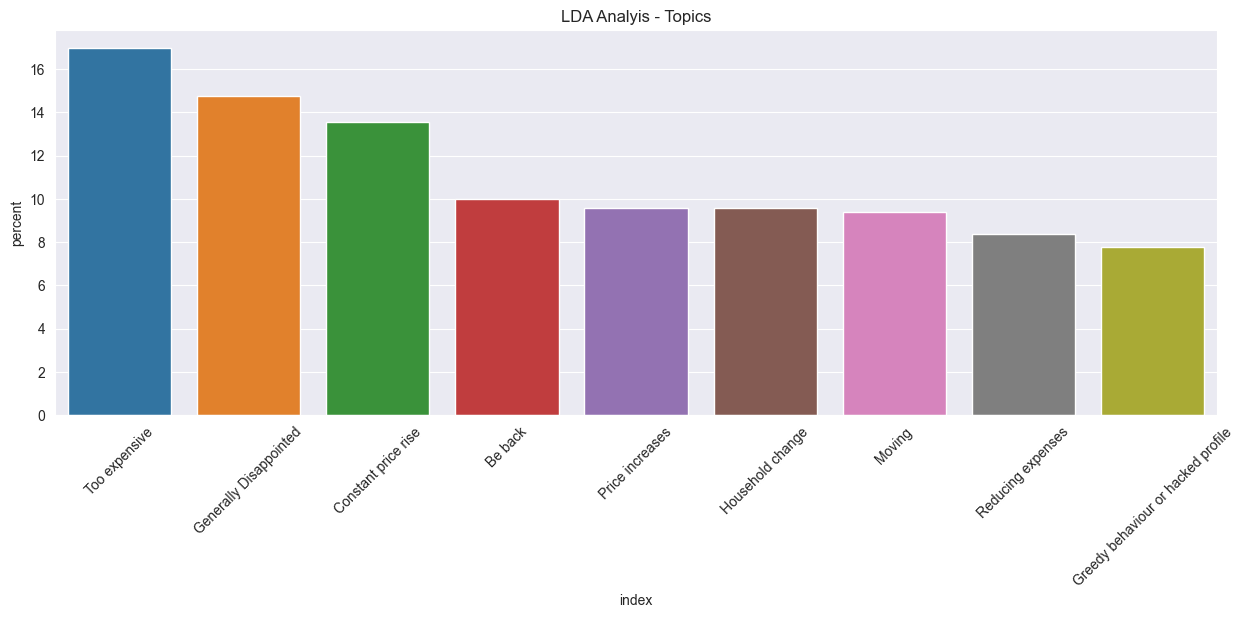

In [160]:
plt.figure(figsize=(15, 5))
plot_df = df_lda['dominant_topic'].value_counts(normalize=True).mul(100).rename('percent').reset_index()
sns.barplot(data=plot_df,  x='index', y='percent')
plt.title('LDA Analyis - Topics')
plt.xticks(rotation = 45)
plt.show()

It looks like the major reason for cancelling is the price, being too expensive (16%), constant rising (14%) and too much increase (10%) or people want to reduce their expenses (8%).
A good part (15%) is generally disappointed by the service or moving/changing household (20% their total) while someone is temporarily canceling but will be back (11%).

We can also see the word cloud per topic.

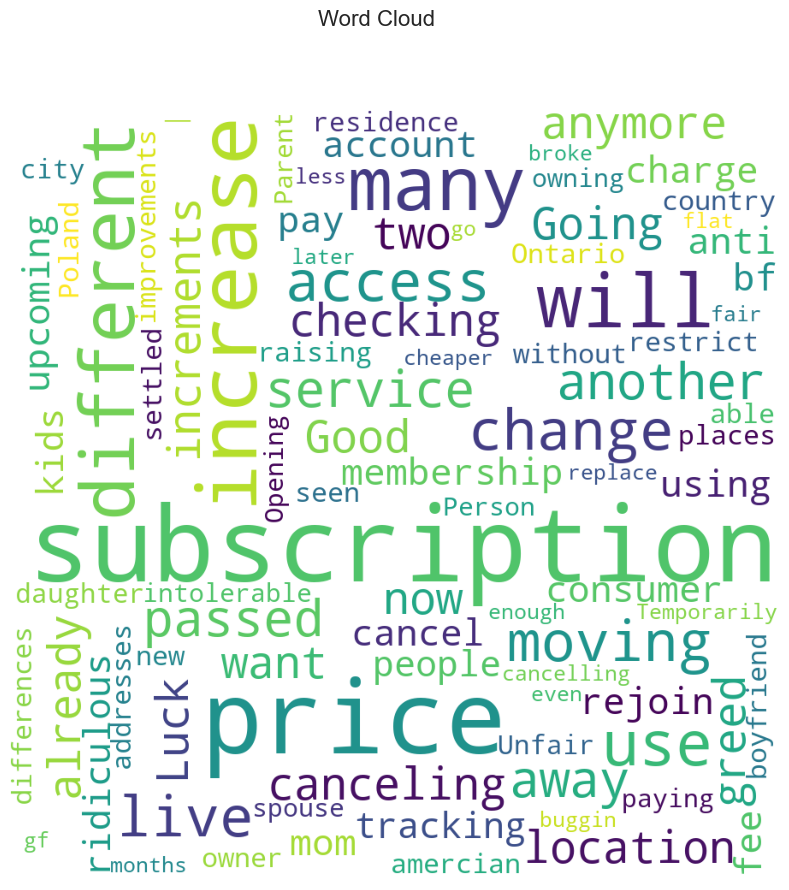

In [161]:
topic_selection = 'Moving'

plot_df = df_lda[df_lda['dominant_topic']==topic_selection]
inputs = plot_df['response'].tolist()
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    from imp import reload
warnings.filterwarnings('ignore')
_wordclouds(inputs, max_words=200)

### Further discussions

Above are just some of the visualizations that could help the analyst's understanding of the language that distinguishes the topics. Other helpful visual could be bar chart of most frequent words per topic, part of speech (POS) analysis or named entity recognition algorithms to find different patterns in the language.

Because of the nature of the short answers, BTM topic model is most suitable for the task, but a regular LDA analysis could be tried to compare the results. Below are some of next steps that could be implemented:
- come up with a metric, that could be accuracy, to evaluate the BTM model with the pre-labeled text (`theme` column)
- improve the model with more text clenup and pre-processing (lemmatization or stemmatization in primis)
- we had to remove answers shorted than 3 words for the BTM mode lto work (in order to create biterms) but we need to work with the whole dataset
- For very short answer the best approach would probably be topic assignment based on root words and matching/similarity to topic label (example: if (root) word is in topic label then assign label)
- More advanced technologies, based on pre-trained transformers, can be used. Example: use sentence embeddings (BERT, GPT series, T5, etc..) and try clustering the hyper-dimensional vectors to get the topics
- BERTopic is another (transformer based model) option for this kind of problem, to experiment with